# Notes

# Imports

In [869]:
%%time
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from lmfit import minimize, Parameter, Parameters, report_fit
from IPython import display
#from progressbar import progressbar
#from numba import jit


CPU times: total: 0 ns
Wall time: 0 ns


# Model diagram

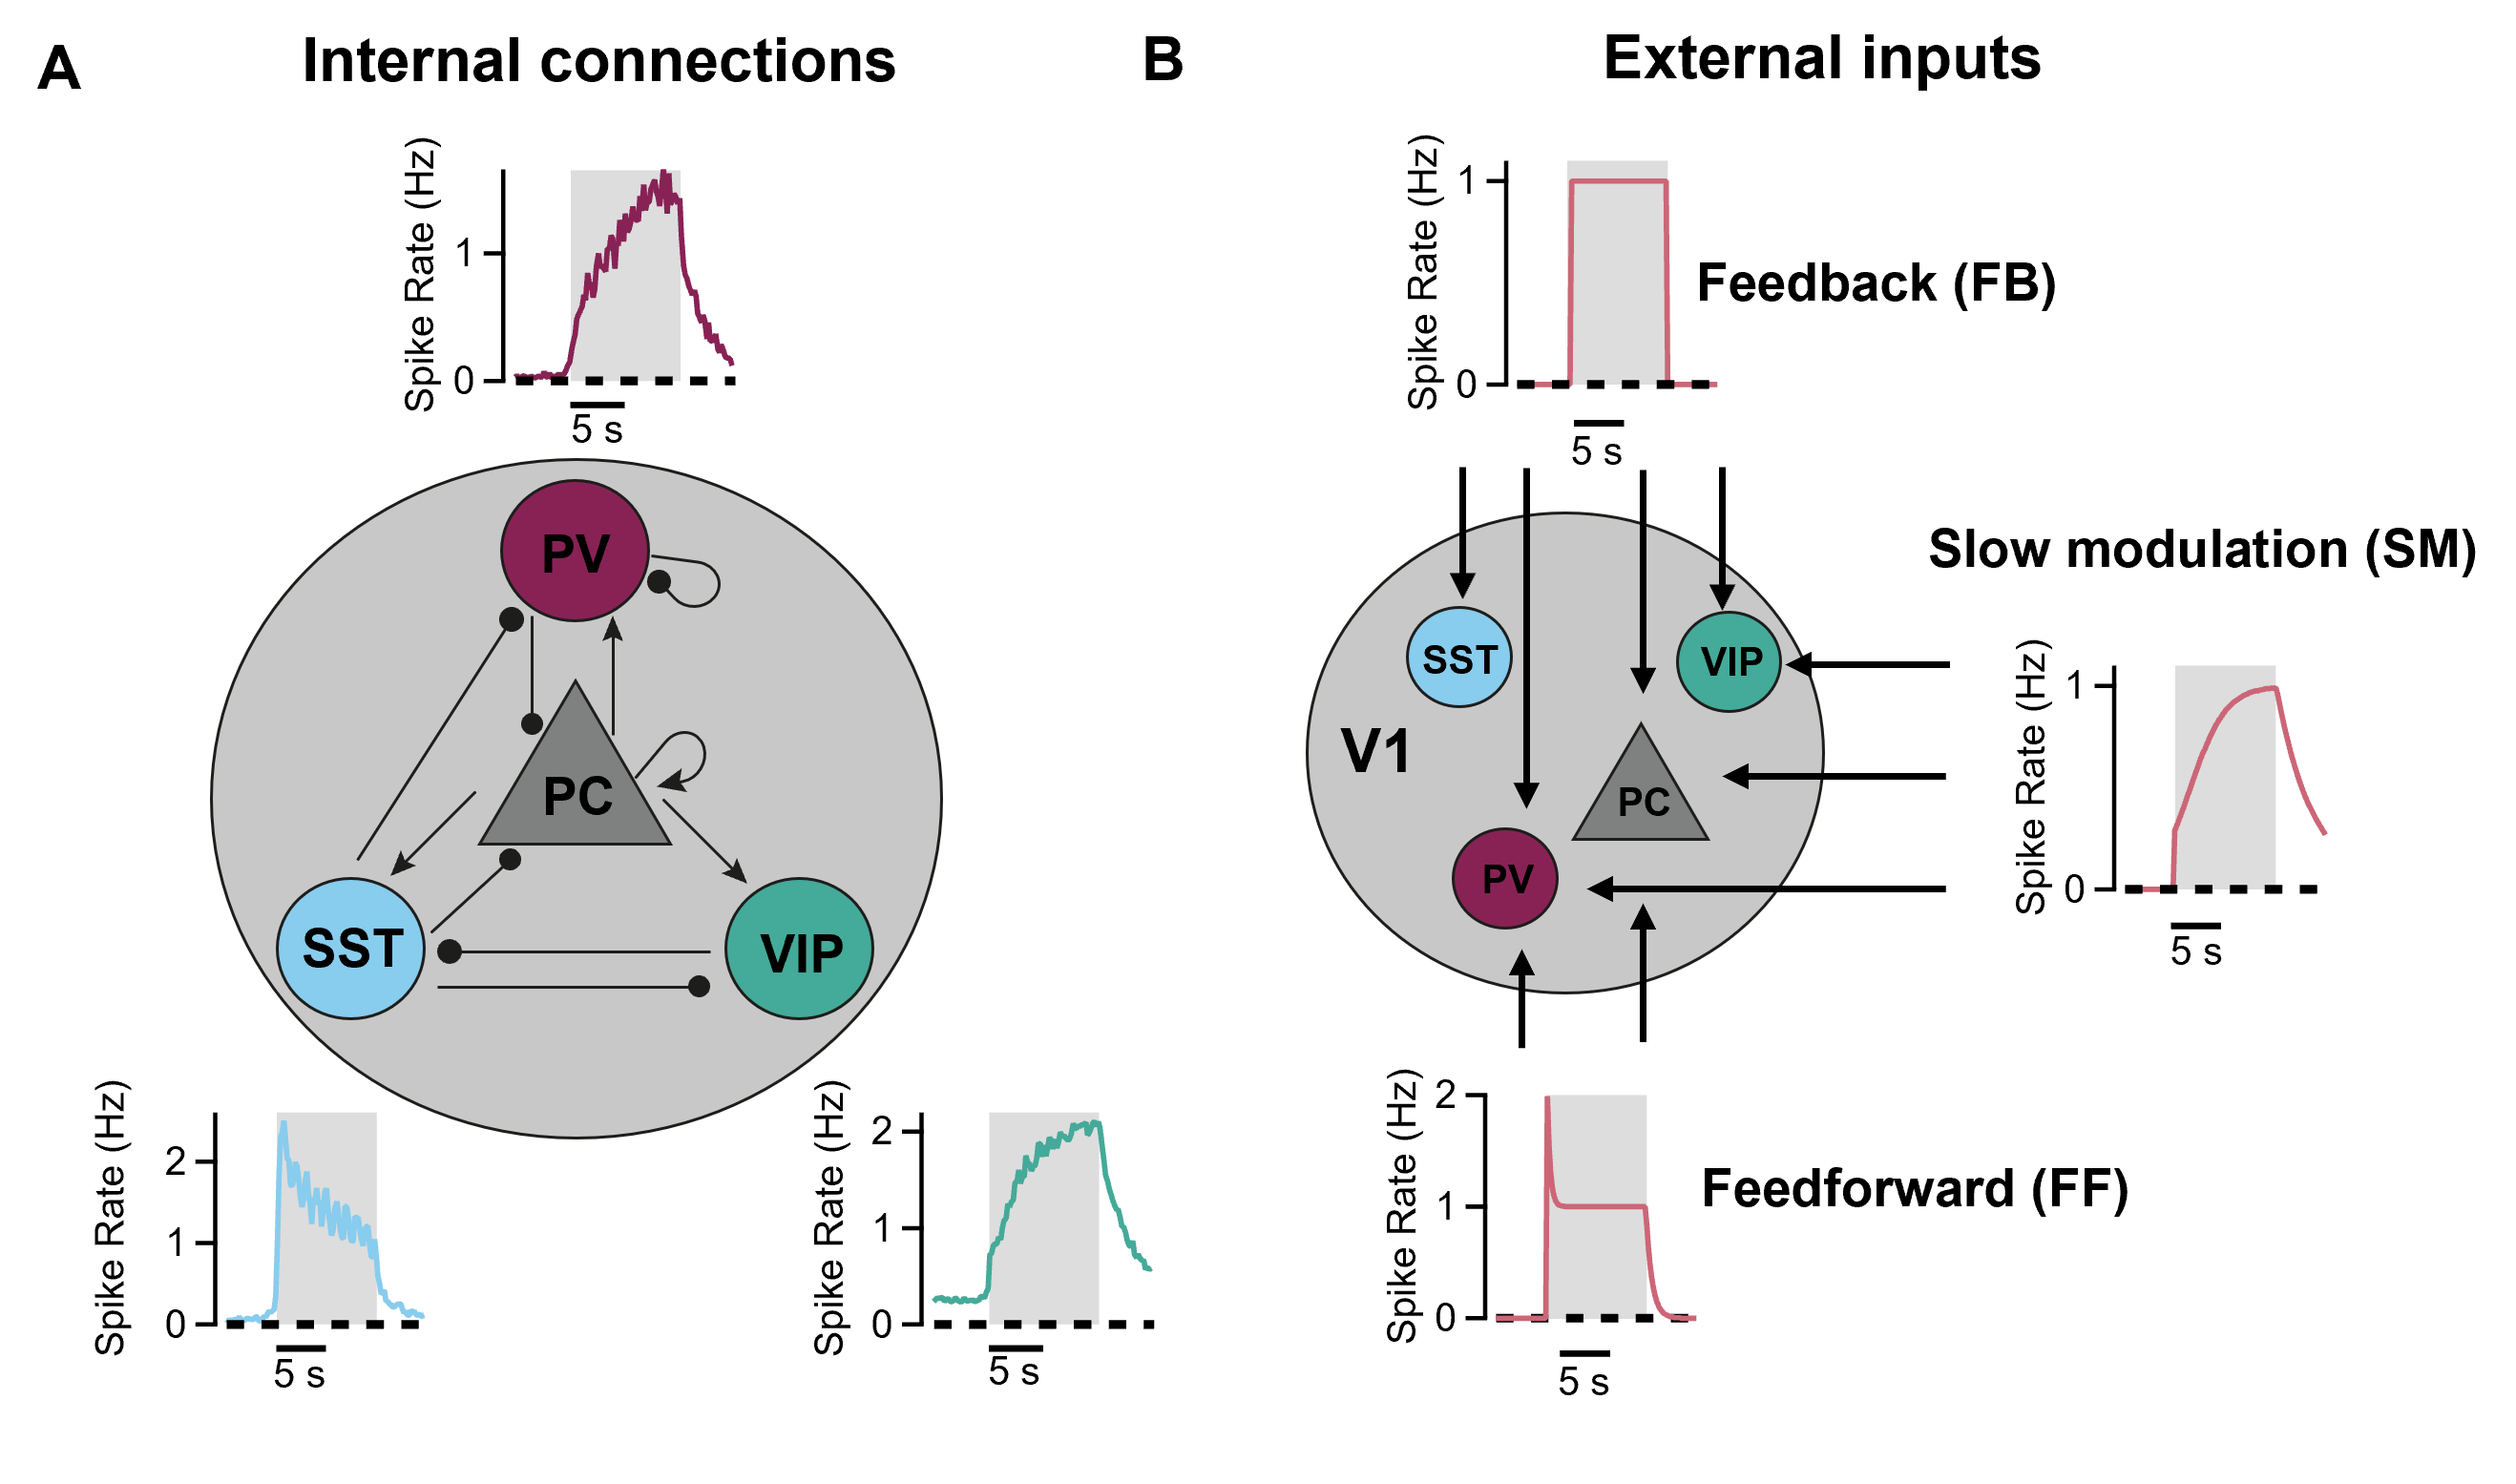

In [870]:
display.Image(r'Model_diagram.png')

In [871]:
# count = 0

# Functions

In [872]:
def exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 1, amp = 1):
    if (t < stim) or (t > stim + inter):
        h = base
    else:
        h = amp*np.exp(-(t-stim)*decay)
    return h

In [873]:
def invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 1, amp = 1, delta = 0):
    if (t < stim) or (t > stim + inter):
        h = base
    else:
        h = (amp)*(t-stim+delta)**(-decay)
    return h

In [874]:
def Step(t, stim = 5, inter = 10, amp = 1.0, base = 0, k = 1, delay = 0, decay_f = 0):
    """
    Step-like output.
    """
    
    if (t < stim + delay):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    # elif (t > stim + inter):
    #     h = amp*np.exp(-(t - stim - inter)*decay_f) + base
    elif (t > stim + inter):
        h = amp * np.exp(-(t - stim - inter)*decay_f)
    else:
        h = amp*(t - stim - delay)*k*0.164745 + amp
    
    return h

In [875]:
def Step_1(t, stim = 5, k = 0, inter = 10, amp = 1.0, base = 1):
    """
    Step-like output.
    """
    
    if (t < stim) or (t > stim + inter):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    else:
        h = amp*(t - stim)*k*0.164745 + amp
    
    return h

In [876]:
def Sigm(t, stim = 5, inter = 10, ampl = 1.0, base = 0, rate = 1, delay = 0, decay_s = 1, dt = 0):
    """
    Step-like output.
    """
    
    if (t < stim):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    elif (t > stim + inter + dt):
        h = (base + (ampl/(1 + np.exp((delay-inter - dt)/rate))))*np.exp(-(t - stim - inter - dt)*decay_s) + base
    
    else:
        h = base + (ampl/(1 + np.exp((stim + delay - t)/rate))) #Actualy rate here is time constant, where 1/rate is actual rate
        
    
    return h

In [877]:
# def expon(t, stim = 5, inter = 10, ampl = 1.5, base = 0, decay = 1, delay = 0, b = 0, decay_ff = 0):
#     if (t < stim + delay):
#         h = b
# #     else:
# #         if t < (stim + 1.5):
# #             h = amp*1.25
#     elif (t > stim + inter):
#         h = (b + base + ampl*np.exp(-(inter-delay)*decay))*np.exp(-(t - stim - inter)*decay_ff)
#     else:
#         h = b + base + ampl*np.exp(-(t - stim - delay)*decay)
        
#     return h

In [878]:
def expon(t, stim = 5, inter = 10, ampl = 1.5, base = 0, decay = 1, delay = 0, b = 0, decay_ff = 0, s_start = 0.1, k = 0.1):
    if (t < stim + delay):
        h = b
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    elif (t > stim + inter):
        h = (b + base + ampl*np.exp(-(inter-delay)*decay)+ (inter - delay - s_start)*k)*np.exp(-(t - stim - inter)*decay_ff)
    elif ((t >= stim + delay) and (t < stim + delay + s_start)):
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)
    else:
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)+ ((t - stim - delay - s_start)*k)
        
    return h

In [879]:
 def f_e_avg(t, data):
     """
    
     """    
    
     return np.interp(t, t_exp, data)

In [880]:
# def f_p(t, data):
#     """
    
#     """    
    
#     return np.interp(t, t_exp, data)

In [881]:
# def f_s(t):
#     """
    
#     """
    
#     return np.interp(t, t_exp, data_sst) 

In [882]:
# def f_v_f(t, data):
#     """
    
#     """    
    
#     return np.interp(t, t_exp, data)

In [883]:
# @jit(parallel=True, fastmath=True)
def model_step(t,
               y,
               w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18,
               tau_0, tau_1, tau_2, tau_3,
               threshold,
               power,
               q,
               i_0, i_1, i_2, i_3,
               r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k
               ):
    """
    Builds differential equation model of visual cortex network with step input h
    """
    
            
    f_e, f_p, f_s, f_v, f_e_o, f_p_o, f_s_o, f_v_o = y
    
    ff_e = (min(max((i_0 + w_0 * f_e + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p - w_4 * f_s), threshold), 25))
    #ff_e_d = (min(max((i_d_0 + w_d_0 * f_e + w_d_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1) + w_d_2 *0* Sigm(t, rate = r_1, delay = delay_2) + w_d_3 * Step(t, k = 0, delay = delay_3) - w_d_4 * f_p - w_d_5 * f_s), threshold), 25))
    ff_p = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p - w_9 * f_s), threshold), 25))
    ff_s = (min(max((i_2 + w_10 * f_e + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v), threshold), 25))
    ff_v = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e - w_14 * f_s +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
        
    ff_e_o = (min(max((i_0 + w_0 * f_e_o + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p_o - w_4 * f_s_o), threshold), 25))
    ff_p_o = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e_o + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p_o - w_9 * f_s_o), threshold), 25)) #*invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1, delta = 1) *Step_1(t, k=-0.2) Step_1(t, amp = 1.0, k=-0.13) exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.01, amp = 1) *invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1)
    ff_s_o = (min(max((i_2 + w_10 * f_e_o + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v_o), threshold), 25))
    ff_v_o = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e_o - w_14 * f_s_o +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
    
        
    df_edt = ((q * ff_e ** power) - f_e) / tau_0
    #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
    df_pdt = ((q * ff_p ** power) - f_p) / tau_1
    df_sdt = ((q * ff_s ** power) - f_s) / tau_2
    df_vdt = ((q * ff_v ** power) - f_v) / tau_3
    
    if (t>=5): #and (t<=15):
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
        df_p_odt = ((q * (ff_p_o/1.8) ** power) - f_p_o) / tau_1 #/1.8 *1.7
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2 #/1.7 *1.4
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
        
    else:
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
        df_p_odt = ((q * (ff_p_o) ** power) - f_p_o) / tau_1
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
    
#     dGdt = (- G + g * D * S) / tau_e
#     dDdt = (1 - D) / tau_d + D * np.log(d) * w_13 * Step(t, amp = 1.5, base = 0.0)
#     dSdt = (1 - S) / tau_s + S * np.log(s) *  w_13 * Step(t, amp = 1.5, base = 0.0)

    dydt = [df_edt, df_pdt, df_sdt, df_vdt, df_e_odt, df_p_odt, df_s_odt, df_v_odt]
    
    return dydt

In [884]:
names = ['w_PC_PC', # w_0
         'w_EX_PC', # w_1
         'w_SI_PC', # w_2
         'w_PV_PC', # w_3
         'w_SS_PC', # w_4
         'w_PC_PV', # w_5
         'w_EX_PV', # w_6
         'w_SI_PV', # w_7
         'w_PV_PV', # w_8
         'w_SS_PV', # w_9
         'w_PC_SS', # w_10
         'w_ST_SS', # w_11
         'w_VI_SS', # w_12
         'w_PC_VI', # w_13
         'w_SS_VI', # w_14
         'w_SI_VI', # w_15
         'w_ST_PC', # w_16
         'w_PC_PC', # w_17
         'w_PC_PC', # w_18
         'w_PC_PC', # w_19
         'w_PC_PC'] # w_20

In [885]:
#@njit(parallel=True, fastmath=True)
def exp_time(start, step, count, endpoint=False):
    """
    Returns NumPy array of experimental timepoints of data
    """
    stop = start+(step*count)
    return np.linspace(start, stop, count, endpoint=endpoint)

In [886]:
#@jit(parallel=True, fastmath=True)
def odesol_step(tt, init, params): 
    """
    Solves ODEs system for step input
    """
    y_init = init
    w_0 = params['w_0'].value
    w_1 = params['w_1'].value
    w_2 = params['w_2'].value
    w_3 = params['w_3'].value
    w_4 = params['w_4'].value
    w_5 = params['w_5'].value
    w_6 = params['w_6'].value
    w_7 = params['w_7'].value
    w_8 = params['w_8'].value
    w_9 = params['w_9'].value
    w_10 = params['w_10'].value
    w_11 = params['w_11'].value
    w_12 = params['w_12'].value
    w_13 = params['w_13'].value
    w_14 = params['w_14'].value
    w_15 = params['w_15'].value
    w_16 = params['w_16'].value
    w_17 = params['w_17'].value
    w_18 = params['w_18'].value
    
    tau_0 = params['tau_0'].value
    tau_1 = params['tau_1'].value
    tau_2 = params['tau_2'].value
    tau_3 = params['tau_3'].value
    threshold = params['threshold'].value
    power = params['power'].value
    q = params['q'].value
    i_0 = params['i_0'].value
    i_1 = params['i_1'].value
    i_2 = params['i_2'].value
    i_3 = params['i_3'].value
    ampl_1 = params['ampl_1'].value
#     ampl_2 = params['ampl_2'].value
#     ampl_3 = params['ampl_3'].value
#     kl = params['kl'].value
#     kl_1 = params['kl_1'].value
#     kl_2 = params['kl_2'].value
#     s_1 = params['s_1'].value
#     s_2 = params['s_2'].value
    r_1 = params['r_1'].value
    delay_1 = params['delay_1'].value
    delay_2 = params['delay_2'].value
    delay_3 = params['delay_3'].value
    decay = params['decay'].value
    decay_s = params['decay_s'].value
    decay_f = params['decay_f'].value
    decay_ff = params['decay_ff'].value
    ampl = params['ampl'].value
    base = params['base'].value
    base_sigm = params['base_sigm'].value
    s_start = params['s_start'].value
    k = params['k'].value
   
    
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    
    return sol

In [887]:
def odesol_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, start_s, k):
    
    y_init = init
    tt = t_exp
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    return sol

In [888]:
def simulate_step(tt, init, params):
    """
    Simulates model
    """
    
#     global count, max_nfev, data_pv
#     #f_e_ = []
#     f_pv_ = []
#     f_sst_ = []
#     f_vip_ = []
    
    sol = odesol_step(tt, init, params)
    
    #print('\r',' ',sol.message, 'count # ', count, '/', end='')
    #print(f'\r {sol.message} Count # {count}/{max_nfev}', end='')
    #print(count)
    #count += 1
    
#     for i in sol.t:
#         #f_e_.append(f_e_avg(i))
#         f_pv_.append(f_p(i, data_pv))
#         f_sst_.append(f_s(i))
#         f_vip_.append(f_v(i))
    
#     print(sol.t)
#     print(sol.y[0])
#     print(np.array(f_pv_))
#     print(np.array(f_sst_))
#     print(np.array(f_vip_))
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o'])
    
    return sim

In [889]:
def simulate_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                   tau_0, tau_1, tau_2, tau_3,
                   threshold,
                   power, 
                   q,
                   i_0, i_1, i_2, i_3,
                   r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k):
    """
    Simulates model
    """
    
#     global count, max_nfev, data_pv
#     #f_e_ = []
#     f_pv_ = []
#     f_sst_ = []
#     f_vip_ = []
    
    sol = odesol_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k)
    
    #print('\r',' ',sol.message, 'count # ', count, '/', end='')
    #print(f'\r {sol.message} Count # {count}/{max_nfev}', end='')
    #print(count)
    #count += 1
    
#     for i in sol.t:
#         #f_e_.append(f_e_avg(i))
#         f_pv_.append(f_p(i, data_pv))
#         f_sst_.append(f_s(i))
#         f_vip_.append(f_v(i))
    
#     print(sol.t)
#     print(sol.y[0])
#     print(np.array(f_pv_))
#     print(np.array(f_sst_))
#     print(np.array(f_vip_))
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o'])
    
    return sim

In [890]:
def residual_step(params, tt, init, data_pc, data_pv, data_sst, data_vip):
    """
    Difference between model and data for further minimization
    """
    global count, max_nfev
    
    weights_sst=np.float32(np.zeros_like(data_pc))
    weights_vip=np.float32(np.zeros_like(data_pc))
    weights_pv=np.float32(np.zeros_like(data_pc))
    weights_pc=np.float32(np.zeros_like(data_pc))
    
    weights_pv[0:24]=1.
    weights_pv[24:36]=0.05
    weights_pv[36:]=1. #:93
    
    #weights_1[85:]=1.
    #weights[50:80]=1.
    weights_sst[0:24]=1.
    weights_sst[24:30]=1.0
    weights_sst[30:93]=3.0
    weights_sst[93:]=1.0
    
    weights_vip[0:24]=1.
    weights_vip[24:30]=1.0
    weights_vip[30:]=1.0
    
    weights_pc[0:24]=1.
    weights_pc[24:30]=0.05
    weights_pc[30:38]=1.
    weights_pc[38:93]=1.
    weights_pc[93:]=1.

    # weights_pv = weights_pv * 3
    # weights_sst = weights_sst * 3
    # weights_pc = weights_pc * 3
    # weights_vip = weights_vip * 3
    
    model = simulate_step(tt, init, params)
    pc_r = (np.float32(np.array(model['f_e'].values - data_pc))*weights_pc/pc_all_err_new).ravel() #/pc_all_err_new
    pv_r = (np.float32(np.array(model['f_pv'].values - data_pv))*weights_pv/pv_err_new).ravel() #/pv_err_new
    sst_r = (np.float32(np.array(model['f_sst'].values - data_sst))*weights_sst/sst_err_new).ravel() # /sst_err_new
    vip_r = (np.float32(np.array(model['f_vip'].values - data_vip))*weights_vip/vip_err_new).ravel() # /vip_err_new
    
    arr = np.concatenate((pc_r,pv_r,sst_r,vip_r), axis=0)
    
    display.clear_output(wait=True)
    plt.figure(figsize = (15,5))
    plt.plot(t_exp, data_pc, color='black', marker='o', label='f_pc(t)')
    plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
    plt.title('leastsq_PC')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.ylim(0, 2.0)
    plt.xticks(np.arange(0,21,1))
    plt.grid()
    text = str(count) + ' ' + '/' + ' ' + str(max_nfev) 
    
    bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)
    plt.text(20.6, 0.45, text, fontsize=12, bbox=bbox, horizontalalignment='right')
    count += 1
    
    plt.show()
    
    
    # plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
    # plt.plot(t_exp, curve, color = 'green', label='input')
    
    
    
    return arr

In [891]:
def residual_ad(params, tt, init, data_pc, data_pc_na):
    """
    Difference between model and data for further minimization
    """
    global count, max_nfev
    
    weights=np.float32(np.zeros_like(data_pc))
    weights_1=np.float32(np.zeros_like(data_pc))
    weights_2=np.float32(np.zeros_like(data_pc))
    weights_1[0:24]=1.
    weights_1[24:35]=0.05
    weights_1[35:91]=1.
    #weights_1[85:]=1.
    #weights[50:80]=1.
    weights[0:24]=1.
    weights[24:30]=0.05
    weights[30:91]=1.
    weights_2[0:24]=1.
    weights_2[24:36]=0.05
    weights_2[30:36]=3.
    weights_2[36:91]=1.
    
    model = simulate_step(tt, init, params)
    #pc_r = np.float32(np.array(model['f_e'].values - data_pc))*weights_2.ravel() #/np.array(pc_sen_err_new)
    pc_d_r = np.array(model['f_e_d'].values - data_pc_na)*weights_2.ravel()
    #pv_r = np.float32(np.array(model['f_pv'].values - data_pv))*weights_1.ravel()
    #sst_r = np.float32(np.array(model['f_sst'].values - data_sst))*weights.ravel()
    #vip_r = np.float32(np.array(model['f_vip'].values - data_vip))*weights.ravel()
    
    #arr = np.concatenate((pc_r,pv_r,sst_r,vip_r), axis=0)
    
    display.clear_output(wait=True)
    plt.figure(figsize = (15,5))
    plt.plot(t_exp, data_pc, color='black', marker='o', label='f_pc(t)')
    plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
    plt.title('leastsq_PC')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.ylim(0, 2.0)
    plt.xticks(np.arange(0,21,1))
    plt.grid()
    text = str(count) + ' ' + '/' + ' ' + str(max_nfev) 
    
    bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)
    plt.text(20.6, 0.45, text, fontsize=12, bbox=bbox, horizontalalignment='right')
    count += 1
    
    plt.show()
    
    
    # plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
    # plt.plot(t_exp, curve, color = 'green', label='input')
    
    
    
    return pc_d_r

In [892]:
def slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k):
    
    model_local = simulate_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k)
    
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    ax[0, 0].plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
    ax[0, 0].plot(t_exp, model_local['f_e'].values, color='blue', label='fit', linewidth=3)
    ax[0, 0].plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
    ax[0, 0].plot(t_exp, model_local['f_e_o'].values, color='red', label='fit', linewidth=3)
    
    ax[1, 0].plot(t_exp, data_pv, color='black', marker='o', label='f_pc(t)')
    ax[1, 0].plot(t_exp, model_local['f_pv'].values, color='blue', label='fit', linewidth=3)
    
    ax[0, 1].plot(t_exp, data_sst, color='black', marker='o', label='f_pc(t)')
    ax[0, 1].plot(t_exp, model_local['f_sst'].values, color='blue', label='fit', linewidth=3)
    
    ax[1, 1].plot(t_exp, data_vip, color='black', marker='o', label='f_pc(t)')
    ax[1, 1].plot(t_exp, model_local['f_vip'].values, color='blue', label='fit', linewidth=3)
    plt.show()
    

In [893]:
def RMSE_full(params, init, data_pc, data_pv, data_sst, data_vip):

    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(len(data_pc)):
        sum += (model['f_e'].values[i] - data_pc[i])**2 + (model['f_pv'].values[i] - data_pv[i])**2 + (model['f_sst'].values[i] - data_sst[i])**2 + (model['f_vip'].values[i] - data_vip[i])**2

    sum_norm = np.sqrt((sum)/(len(data_pc)*4))

    return sum_norm

In [894]:
def RMSE_full_1(params, init, data_pc, data_pv, data_sst, data_vip):

    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(31,91):
        sum += (model['f_e'].values[i] - data_pc[i])**2 + (model['f_pv'].values[i] - data_pv[i])**2 + (model['f_sst'].values[i] - data_sst[i])**2 + (model['f_vip'].values[i] - data_vip[i])**2

    sum_norm = np.sqrt((sum)/(len(data_pc)*4))

    return sum_norm

In [895]:
def RMSE(params, init, data, type):

    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(31, 91):
        sum += (model[type].values[i] - data[i])**2

    sum = np.sqrt((sum)/len(data))

    return sum

# Experimental data

In [896]:
pc_sen = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Sen_Avg.txt')
pc_dep = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Dep_Avg.txt')
#f_e_exp_3 = np.loadtxt(r'Experimental data\Updated_again\PC_AllFil_Sess1_firingrate_10_11_2023.txt')
pc_na = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_NA_Avg.txt')
pc_all = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_AvgSess1.txt')
pc_sen_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Sen_SEM.txt')
pc_dep_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Dep_SEM.txt')
pc_na_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_NA_SEM.txt')
pc_opto_pv_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVArChT1_Opto.txt')
pc_opto_pv_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVChR1_Opto.txt')
pc_opto_sst_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTArchT1_Opto.txt')
pc_opto_sst_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTChR1_Opto.txt')
pc_all_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_SEMSess1.txt')
#print(f_e_exp_1)
t_exp_1 = exp_time(start=0.0, step=0.164745, count=len(pc_sen))
#print(t_exp_1)
print(len(pc_sen), len(t_exp_1))

183 183


In [897]:
pv = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_AvgSess.txt')
pv_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_SEMSess.txt')
#print(f_e_exp_1)
t_pv_exp_1 = exp_time(start=0.0, step=0.164745, count=len(pv))
#print(t_exp_1)
print(len(pv), len(t_pv_exp_1))

183 183


In [898]:
# pv_new = f_pv_exp_1[0:122]
# t_ca_new = t_pv_exp_1[0:122]
# plt.plot(t_ca_new, pv_new, marker = 'x', label = 'pv', color='orange')
# plt.legend()
# plt.show()

In [899]:
# a = [f_pv_exp_1[121]]
# b = [t_pv_exp_1[121]]
# c = []
# for i in range(0,61):
#     a.append(a[-1]*np.exp(-1.0392*0.164745))
#     b.append(b[-1] + 0.164745)

# for i in t_exp_1:
#     c.append(Step(i, stim = 5, amp = 0.5, base = 0.0))
    

# pv_new = np.append(pv_new, a)
# t_ca_new = np.append(t_ca_new, b)

# plt.plot(t_exp_1, f_e_exp_4, marker = 'x', label = 'pc_avg')
# plt.plot(t_exp_1, f_pv_exp_1, marker = 'x', label = 'pv_old')
# plt.plot(t_exp_1, c)
# plt.plot(t_ca_new, pv_new, marker = 'x', label = 'pv_new')
# plt.legend()
# plt.show()

In [900]:
sst = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_AvgSess.txt')
sst_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_SEMSess.txt')
#print(f_e_exp_1)
t_sst_exp_1 = exp_time(start=0.0, step=0.164745, count=len(sst))
#print(t_exp_1)
print(len(sst), len(t_sst_exp_1))

183 183


In [901]:
vip = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_AvgSess.txt')
vip_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_SEMSess.txt')
#print(f_e_exp_1)
t_vip_exp_1 = exp_time(start=0.0, step=0.164745, count=len(vip))
#print(t_exp_1)
print(len(vip), len(t_vip_exp_1))

183 183


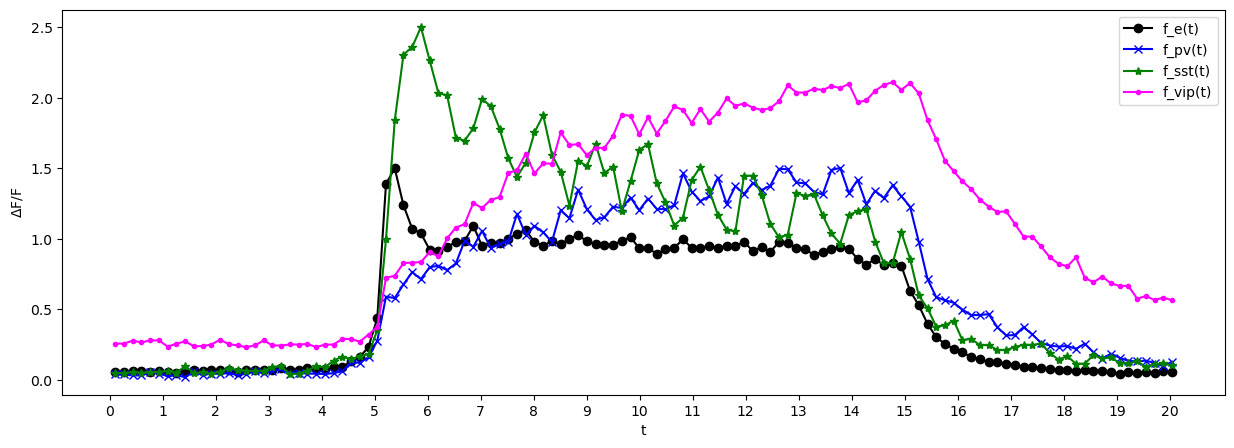

In [902]:
dt = 0.164745

t_exp_1_new = []
pc_sen_new = []
#f_e_avg_l = []
pv_new = []
#f_pv_excite = []
sst_new = []
vip_new = []
pc_na_new = []
pc_dep_new = []
pc_all_new = []
pc_sen_err_new = []
pc_dep_err_new = []
pc_na_err_new = []
pc_all_err_new = []
pv_err_new = []
sst_err_new = []
vip_err_new = []
pc_opto_pv_arch_new = []
pc_opto_pv_chr_new = []
pc_opto_sst_chr_new = []
pc_opto_sst_arch_new = []

for ind, time in np.ndenumerate(t_exp_1):
    if (time >= 5) and (time <= 25):
        t_exp_1_new.append(time - 5)
        pc_sen_new.append(pc_sen[ind])
        #f_e_avg_l.append(f_e_exp_3[ind])
        pv_new.append(pv[ind])
        sst_new.append(sst[ind])
        vip_new.append(vip[ind])
        pc_na_new.append(pc_na[ind])
        pc_dep_new.append(pc_dep[ind])
        pc_all_new.append(pc_all[ind])
        #f_pv_excite.append(pv_new[ind])
        pc_sen_err_new.append(pc_sen_err[ind])
        pc_dep_err_new.append(pc_dep_err[ind])
        pc_na_err_new.append(pc_na_err[ind])
        pv_err_new.append(pv_err[ind])
        sst_err_new.append(sst_err[ind])
        vip_err_new.append(vip_err[ind])
        pc_opto_pv_arch_new.append(pc_opto_pv_arch[ind])
        pc_opto_pv_chr_new.append(pc_opto_pv_chr[ind])
        pc_opto_sst_chr_new.append(pc_opto_sst_chr[ind])
        pc_opto_sst_arch_new.append(pc_opto_sst_arch[ind])
        pc_all_err_new.append(pc_all_err[ind])
        
        
pc_sen_new.insert(0, pc_sen_new[0])
pv_new.insert(0, pv_new[0])
sst_new.insert(0, sst_new[0])
vip_new.insert(0, vip_new[0])
pc_na_new.insert(0, pc_na_new[0])
pc_dep_new.insert(0, pc_dep_new[0])
pc_all_new.insert(0, pc_all_new[0])
pc_sen_err_new.insert(0, pc_sen_err_new[0])
pc_dep_err_new.insert(0, pc_dep_err_new[0])
pc_na_err_new.insert(0, pc_na_err_new[0])
pv_err_new.insert(0, pv_err_new[0])
sst_err_new.insert(0, sst_err_new[0])
vip_err_new.insert(0, vip_err_new[0])
pc_opto_pv_arch_new.insert(0, pc_opto_pv_arch_new[0])
pc_opto_pv_chr_new.insert(0, pc_opto_pv_chr_new[0])
pc_opto_sst_chr_new.insert(0, pc_opto_sst_chr_new[0])
pc_opto_sst_arch_new.insert(0, pc_opto_sst_arch_new[0])
pc_all_err_new.insert(0, pc_all_err_new[0])

#t_exp_1_new = np.linspace(start=0, stop=(len(pc_sen_new)-1)*dt, num=len(pc_sen_new))
t_exp_1_new.append(t_exp_1_new[-1] + dt)
        
plt.figure(figsize=(15,5))
plt.plot(t_exp_1_new, pc_all_new, color='black', marker='o', label='f_e(t)')
plt.plot(t_exp_1_new, pv_new, color='blue', marker='x', label='f_pv(t)')
plt.plot(t_exp_1_new, sst_new, color='green', marker='*', label='f_sst(t)')
plt.plot(t_exp_1_new, vip_new, color='magenta', marker='.', label='f_vip(t)')
#plt.plot(t_exp_1_new, f_pv_excite, color='orange', marker='v', label='external')

plt.legend(loc='best')
plt.ylabel(r'$\Delta$F/F')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [903]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp_1_new[31:91], data_pc_all[31:91], color='blue', marker='o', label='f_e(t)')
# plt.plot(t_exp_1_new[90:], vip_new[90:], color='black', marker='o', label='f_e(t)')

# plt.legend(loc='best')
# plt.ylabel(r'$\Delta$F/F')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,21,1))
# plt.grid()
# plt.show()

# Variables and constants

In [904]:
t = np.float32(np.array(t_exp_1_new))
t_exp = t
threshold = np.float32(0) 

power = np.float32(2.0)
q = np.float32(1.0)

ampl_1 = 1.0
# ampl_2 = 5.0
# ampl_3 = 0
# kl = 0
# kl_1 = 0
# kl_2 = 0
# s_1 = 0.10
# s_2 = 0.10

r_1 = np.float32(1.713939)
delay_1 = np.float32(0.1650418)
delay_2 = np.float32(1.73305)
delay_3 = np.float32(0.3695274)
decay = np.float32(3.324089)
decay_s = np.float32(0.2685497)
decay_f = np.float32(0.8342502)
decay_ff = np.float32(2.152722)
ampl = np.float32(1.0)
base = np.float32(1.0)
base_sigm = np.float32(0)
s_start = np.float32(0.1835884)
k = np.float32(0.03068755)

init = np.float32(np.array([0.055, 0.011, 0.017, 0.208, 0.055, 0.011, 0.017, 0.208]))
tau = np.float32(np.array([0.015, 0.0075, 0.019, 0.019]))
#tau_s = np.array([100, 1, 15, 0.5])
i = np.float32(np.array([0.26580502, 0.01447602, 0.11203215, 0.51341198]))
w = np.float32(np.array([
              0.08281103, # w_0  PC  -> PC        
              1.51969985, # w_1  FF  -> PC
              1.06618999, # w_2  SM   -> PC
              1.95560664, # w_3  PV -> PC
              0.63190096, # w_4  SST  -> PC
              0.20723919, # w_5  PC   -> PV
              0.92636845, # w_6  FF  -> PV
              2.11169434, # w_7  SM -> PV
              1.51029559, # w_8  PV   -> PV
              0.25013329, # w_9  SST  -> PV
              0.78370724, # w_10 PC -> SST
              0.59415933, # w_11 FB  -> SST
              0.14997032, # w_12 VIP  -> SST
              0.32398988, # w_13 PC  -> VIP
              0.19112577, # w_14 SST  -> VIP
              0.73762300, # w_15 SM  -> VIP
              1.14600083, # w_16 FB  -> PC
              0.17580747, # w_17 FB  -> PV
              0.15806817]))# w_18 FB -> VIP


# g = 1
# d = 0.9478
# s = 0.9999
# tau_d = 0.4429
# tau_s = 13.8823
# tau_e = 2e-3

data_pc_sen = np.float32(np.array(pc_sen_new)) * 0.333 #proportion of cells relative to PC
#data_pc_avg = f_e_avg_l
data_pv = np.float32(np.array(pv_new)) #proportion of cells relative to PC
data_sst = np.float32(np.array(sst_new)) #proportion of cells relative to PC
data_vip = np.float32(np.array(vip_new)) #proportion of cells relative to PC
data_pc_na = np.float32(np.array(pc_na_new)) * 0.333 #proportion of cells relative to PC
data_pc_dep = np.float32(np.array(pc_dep_new)) * 0.333 #proportion of cells relative to PC
data_pc_all = np.float32(np.array(pc_all_new))
data_pc_opto_pv_arch = np.float32(np.array(pc_opto_pv_arch_new))
data_pc_opto_pv_chr = np.float32(np.array(pc_opto_pv_chr_new))
data_pc_opto_sst_chr = np.float32(np.array(pc_opto_sst_chr_new))
data_pc_opto_sst_arch = np.float32(np.array(pc_opto_sst_arch_new))
pv_err_new = np.array(pv_err_new)
sst_err_new = np.array(sst_err_new)
vip_err_new = np.array(vip_err_new)

#data_pv_exc = f_pv_excite

count = 0
max_nfev = 2000

In [905]:
print(len(data_pc_sen))

122


In [906]:
# weights=np.zeros_like(data_pc)
# weights[18:]=1
# print(weights)

## Parameters

In [907]:
params = Parameters()
params.add('w_0', value = w[0] , vary = True, min = 0.05, max = 6)
params.add('w_1', value = w[1] , vary = True, min = 0.0, max = 6)
params.add('w_2', value = w[2] , vary = True, min = 0.0, max = 6)
params.add('w_3', value = w[3] , vary = True, min = 0.0, max = 6)
params.add('w_4', value = w[4] , vary = True, min = 0.0, max = 6)
params.add('w_5', value = w[5] , vary = True, min = 0.0, max = 6)
params.add('w_6', value = w[6] , vary = True, min = 0.0, max = 6)
params.add('w_7', value = w[7] , vary = True, min = 0.0, max = 6)
params.add('w_8', value = w[8] , vary = True, min = 0.0, max = 6)
params.add('w_9', value = w[9] , vary = True, min = 0.0, max = 6)
params.add('w_10', value = w[10] , vary = True, min = 0.0, max = 6)
params.add('w_11', value = w[11] , vary = True, min = 0.0, max = 6)
params.add('w_12', value = w[12] , vary = True, min = 0.0, max = 6)
params.add('w_13', value = w[13] , vary = True, min = 0.3, max = 6)
params.add('w_14', value = w[14] , vary = True, min = 0.0, max = 6)
params.add('w_15', value = w[15] , vary = True, min = 0.0, max = 6)
params.add('w_16', value = w[16] , vary = True, min = 0.0, max = 6)
params.add('w_17', value = w[17] , vary = True, min = 0.0, max = 6)
params.add('w_18', value = w[18] , vary = True, min = 0.0, max = 6)

#params.add('w_13', value = w[13] , vary = True, min = 0.1, max = 25)
params.add('tau_0', value = tau[0] , vary = False, min = 0.001, max = 0.03)
params.add('tau_1', value = tau[1] , vary = False, min = 0.001, max = 0.03)
params.add('tau_2', value = tau[2] , vary = False, min = 0.001, max = 0.03)
params.add('tau_3', value = tau[3] , vary = False, min = 0.001, max = 0.03)
params.add('threshold', value = threshold , vary = False, min = -np.inf, max = np.inf)
params.add('power', value = power , vary = False, min = 0.5, max = 2.5)
params.add('q', value = q, vary = False, min = 0.001, max = 2.5 )
params.add('i_0', value = i[0] , vary = True, min = 0.0, max = 0.7)
params.add('i_1', value = i[1] , vary = True, min = 0.0, max = 0.7)
params.add('i_2', value = i[2] , vary = True, min = 0.0, max = 0.7)
params.add('i_3', value = i[3] , vary = True, min = 0.0, max = 0.7)

params.add('ampl_1', value = ampl_1 , vary = False, min = 0.8, max = 1.5)
# params.add('ampl_2', value = ampl_2 , vary = True, min = 0, max = 15)
# params.add('ampl_3', value = ampl_3 , vary = False, min = 0, max = 7)
# params.add('kl', value = kl , vary = False, min = -15, max = 7)
# params.add('kl_1', value = kl_1 , vary = False, min = -10, max = 0)
# params.add('kl_2', value = kl_2 , vary = False, min = 0, max = 10)
# params.add('s_1', value = s_1 , vary = True, min = 0, max = 5)
# params.add('s_2', value = s_2 , vary = True, min = 0, max = 5)

params.add('r_1', value = r_1, vary = True, min = 0, max = 5)
params.add('delay_1', value = delay_1, vary = True, min = 0, max = 1.5)
params.add('delay_2', value = delay_2, vary = True, min = 0, max = 25)
params.add('delay_3', value = delay_3, vary = True, min = 0, max = 3)
params.add('decay', value = decay, vary = True, min = 0, max = 10)
params.add('decay_s', value = decay_s, vary = True, min = 0, max = 10)
params.add('decay_f', value = decay_f, vary = True, min = 0, max = 10)
params.add('decay_ff', value = decay_ff, vary = True, min = 0, max = 10)
params.add('ampl', value = ampl, vary = True, min = 0, max = 5)
params.add('base', value = base, vary = False, min = 0, max = 5)
params.add('base_sigm', value = base_sigm, vary = False, min = 0, max = 2)
params.add('s_start', value = s_start, vary = True, min = 0, max = 4)
params.add('k', value = k, vary = True, min = 0.03, max = 2)
# params.add('g', value = g , vary = False, min = 0.005, max = 1.0)
# params.add('d', value = d , vary = True, min = 0.4, max = 1.0)
# params.add('s', value = s , vary = True, min = 0.9, max = 1.0)
# params.add('tau_d', value = tau_d , vary = True, min = 0.3, max = 1.0)
# params.add('tau_s', value = tau_s , vary = True, min = 10.0, max = 30.0)
# params.add('tau_e', value = tau_e , vary = False, min = 0.0005, max = 50.0)
params

name,value,initial value,min,max,vary
w_0,0.08281103,0.08281102776527405,0.05000000,6.00000000,True
w_1,1.51969981,1.5196998119354248,0.00000000,6.00000000,True
w_2,1.06619000,1.0661900043487549,0.00000000,6.00000000,True
w_3,1.95560670,1.9556066989898682,0.00000000,6.00000000,True
w_4,0.63190097,0.63190096616745,0.00000000,6.00000000,True
w_5,0.20723920,0.20723919570446014,0.00000000,6.00000000,True
w_6,0.92636847,0.9263684749603271,0.00000000,6.00000000,True
w_7,2.11169434,2.1116943359375,0.00000000,6.00000000,True
w_8,1.51029563,1.5102956295013428,0.00000000,6.00000000,True
w_9,0.25013328,0.2501332759857178,0.00000000,6.00000000,True


In [908]:
#print(f_s(t_exp[1]))

In [909]:
# heat = pd.DataFrame()
# heat[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
# heat['PC'] = [0.01222982, 2.25251760, 2.70988047, None, 0.97270781, 1.53293469, 1.32938450]
# heat['PV'] = [0.66931084, 1.39211370, 1.14684455, None, 0.22043244, 1.90878325, None]
# heat['SST'] = [0.17210378, None, None, 0.15543846, None, None, 0.65516905]
# heat['VIP'] = [0.04639222, None, 0.00206863, None, None, 0.79944357, None]
# heat.set_index('', inplace = True)

In [910]:
# heat_new = pd.DataFrame()
# heat_new[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
# heat_new['PC'] = [params["w_0"].value, params["w_3"].value, params["w_4"].value, None, params["w_1"].value, params["w_2"].value, params["w_16"].value]
# heat_new['PV'] = [params["w_5"].value, params["w_8"].value, params["w_9"].value, None, params["w_6"].value, params["w_7"].value, None]
# heat_new['SST'] = [params["w_10"].value, None, None, params["w_12"].value, None, None, params["w_11"].value]
# heat_new['VIP'] = [params["w_13"].value, None, params["w_14"].value, None, None, params["w_15"].value, None]
# heat_new.set_index('', inplace = True)

In [911]:
# fig, ax = plt.subplots(1, 2, figsize=(13, 5))
# sns.heatmap(heat, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black')
# sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black')
# ax[0].set_title("Old")
# ax[1].set_title("New")

In [912]:
print(len(t_exp), t_exp)

122 [ 0.107095  0.27184   0.436585  0.60133   0.766075  0.93082   1.095565
  1.26031   1.425055  1.5898    1.754545  1.91929   2.084035  2.24878
  2.413525  2.57827   2.743015  2.90776   3.072505  3.23725   3.401995
  3.56674   3.731485  3.89623   4.060975  4.22572   4.390465  4.55521
  4.719955  4.8847    5.049445  5.21419   5.378935  5.54368   5.708425
  5.87317   6.037915  6.20266   6.367405  6.53215   6.696895  6.86164
  7.026385  7.19113   7.355875  7.52062   7.685365  7.85011   8.014855
  8.1796    8.344345  8.50909   8.673835  8.83858   9.003325  9.16807
  9.332815  9.49756   9.662305  9.82705   9.991795 10.15654  10.321285
 10.48603  10.650775 10.81552  10.980265 11.14501  11.309755 11.4745
 11.639245 11.80399  11.968735 12.13348  12.298225 12.46297  12.627715
 12.79246  12.957205 13.12195  13.286695 13.45144  13.616185 13.78093
 13.945675 14.11042  14.275165 14.43991  14.604655 14.7694   14.934145
 15.09889  15.263635 15.42838  15.593125 15.75787  15.922615 16.08736
 16.252106

In [913]:
w_0 = params['w_0'].value
w_1 = params['w_1'].value
w_2 = params['w_2'].value
w_3 = params['w_3'].value
w_4 = params['w_4'].value
w_5 = params['w_5'].value
w_6 = params['w_6'].value
w_7 = params['w_7'].value
w_8 = params['w_8'].value
w_9 = params['w_9'].value
w_10 = params['w_10'].value
w_11 = params['w_11'].value
w_12 = params['w_12'].value
w_13 = params['w_13'].value
w_14 = params['w_14'].value
w_15 = params['w_15'].value
w_16 = params['w_16'].value
w_17 = params['w_17'].value
w_18 = params['w_18'].value
    
tau_0 = params['tau_0'].value
tau_1 = params['tau_1'].value
tau_2 = params['tau_2'].value
tau_3 = params['tau_3'].value
threshold = params['threshold'].value
power = params['power'].value
q = params['q'].value
i_0 = params['i_0'].value
i_1 = params['i_1'].value
i_2 = params['i_2'].value
i_3 = params['i_3'].value
ampl_1 = params['ampl_1'].value
#     ampl_2 = params['ampl_2'].value
#     ampl_3 = params['ampl_3'].value
#     kl = params['kl'].value
#     kl_1 = params['kl_1'].value
#     kl_2 = params['kl_2'].value
#     s_1 = params['s_1'].value
#     s_2 = params['s_2'].value
r_1 = params['r_1'].value
delay_1 = params['delay_1'].value
delay_2 = params['delay_2'].value
delay_3 = params['delay_3'].value
decay = params['decay'].value
decay_s = params['decay_s'].value
decay_f = params['decay_f'].value
decay_ff = params['decay_ff'].value
ampl = params['ampl'].value
base = params['base'].value
base_sigm = params['base_sigm'].value
s_start = params['s_start'].value
k = params['k'].value

In [914]:
%matplotlib inline
from ipywidgets import interactive, fixed
import ipywidgets as widgets
interactive(slider, 
            w_0 = fixed(w_0), # widgets.IntSlider(min=0, max=2, step=0.1, value=w_0)
            w_1=fixed(w_1), w_2=fixed(w_2), w_3=widgets.FloatSlider(min=0, max=5, step=0.1, value=w_3), w_4=widgets.FloatSlider(min=0, max=7, step=0.1, value=w_4), w_5=fixed(w_5), 
            w_6=fixed(w_6), w_7=widgets.FloatSlider(min=0, max=3, step=0.1, value=w_7), w_8=fixed(w_8), w_9=fixed(w_9), w_10=fixed(w_10), 
            w_11=fixed(w_11), w_12=fixed(w_12), w_13=fixed(w_13), w_14=fixed(w_14), w_15=fixed(w_15), 
            w_16=fixed(w_16), w_17=fixed(w_17), w_18=fixed(w_18), 
            tau_0=fixed(tau_0), tau_1=fixed(tau_1), tau_2=fixed(tau_2), tau_3=fixed(tau_3),
            threshold=fixed(threshold), power=fixed(power), q=fixed(q),
            i_0=fixed(i_0), i_1=fixed(i_1), i_2=fixed(i_2), i_3=fixed(i_3),
            r_1=fixed(r_1), decay=fixed(decay), delay_1=fixed(delay_1), delay_2=fixed(delay_2), delay_3=fixed(delay_3), ampl=fixed(ampl),
            base=fixed(base), decay_s=fixed(decay_s), ampl_1=fixed(ampl_1), base_sigm=fixed(base_sigm), decay_f=fixed(decay_f), decay_ff=fixed(decay_ff), s_start=fixed(s_start), k=fixed(k))

interactive(children=(FloatSlider(value=1.9556066989898682, description='w_3', max=5.0), FloatSlider(value=0.6…

In [915]:
#model = simulate_step(t_exp, init, params)
#print(model, 2*'\n', len(model))

In [916]:
# plt.plot(model['t'], model['f_e'])
# plt.ylim(0,5)
# plt.show()

In [917]:
model = simulate_step(t_exp, init, params)

In [918]:
# display.display(display.HTML(model[['t', 'f_e_o']].to_html()))
#model[['t', 'f_e_o']].to_csv('out_sst_arch_c_13p0.csv', index=False)
#model[['t', 'f_e', 'f_pv', 'f_sst', 'f_vip']].to_csv('out_naive.csv', index=False)

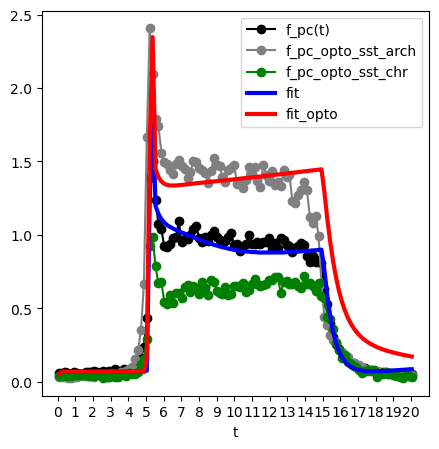

In [919]:
plt.figure(figsize=(5,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
#plt.plot(t_exp, data_pc_opto_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_opto_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
plt.plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
plt.plot(t_exp, data_pc_opto_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_e_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
#plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [920]:
a = RMSE(params, init, data_pc_opto_pv_arch, "f_e_o")
print(a)

0.11050454980119635


In [921]:
a_tot = RMSE_full(params, init, data_pc_all, data_pv, data_sst, data_vip)
print(a_tot)

0.11409275728459924


In [922]:
a_tot_1 = RMSE_full_1(params, init, data_pc_all, data_pv, data_sst, data_vip)
print(a_tot_1)

0.09315313214718823


In [923]:
model[['t', 'f_e_o']].to_csv('trace_s1_hab_Loco_PVArch_30_05_2025.csv', index=False)

In [645]:
print(model['f_e_o'].values)
print(model['f_e'].values)
for i,t in enumerate(t_exp):
    print(t, data_sst[i])

[0.055      0.06800794 0.06800987 0.06801015 0.06800988 0.06801021
 0.06801019 0.06801118 0.06801112 0.06801153 0.068012   0.06801281
 0.06801173 0.06801368 0.06801065 0.06801119 0.06801158 0.06801018
 0.06800906 0.06800968 0.06801003 0.0680086  0.06800998 0.0680091
 0.06801038 0.06801071 0.06801088 0.06801113 0.06801166 0.06801183
 0.07626102 1.56829724 2.40217856 1.96672624 1.86495855 1.79884076
 1.75262661 1.71704054 1.6895005  1.66432031 1.64212124 1.62153714
 1.60093997 1.58123    1.56008887 1.5411299  1.52023589 1.5011501
 1.48418948 1.46437625 1.44810466 1.43113752 1.41383922 1.40065835
 1.38450751 1.37063353 1.35789628 1.34698577 1.3372223  1.32523438
 1.31728572 1.30963451 1.30191821 1.29516264 1.2891297  1.28269869
 1.2772801  1.27503657 1.26942307 1.26854648 1.26509158 1.26237972
 1.26227586 1.26179472 1.26100654 1.26046314 1.26042951 1.26092062
 1.26178261 1.2626697  1.26314506 1.2632863  1.26504268 1.26828204
 1.26974626 1.27019466 1.27432206 1.27589158 1.2778477  1.281669

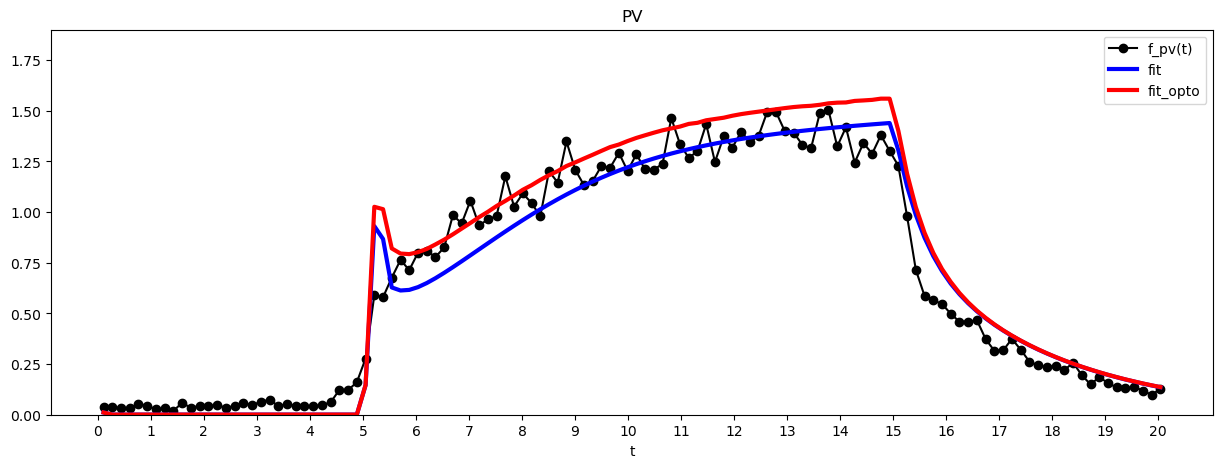

In [577]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, data_pc_all, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, fast, color='green', label='fit', linewidth=3)
#plt.plot(t_exp, slow, color='orange', label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.9)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [578]:
print(model['f_pv'].values)
print(model['f_pv_o'].values)
print(model['f_pv'].values/model['f_pv_o'].values)
print((model['f_pv'].values/model['f_pv_o'].values).mean())
print((model['f_pv_o'].values/model['f_pv'].values).mean())
print(model['f_pv'].values.mean()/model['f_pv_o'].values.mean())
print(model['f_pv_o'].values.mean()/model['f_pv'].values.mean())

[1.09999999e-02 5.72617963e-04 5.72021155e-04 5.72358276e-04
 5.72029613e-04 5.72427590e-04 5.72402840e-04 5.73572022e-04
 5.73506565e-04 5.73981887e-04 5.74545670e-04 5.75498402e-04
 5.74227608e-04 5.76535596e-04 5.72949540e-04 5.73581964e-04
 5.74050395e-04 5.72393832e-04 5.71059264e-04 5.71799781e-04
 5.72212517e-04 5.70524074e-04 5.72156748e-04 5.71115260e-04
 5.72629939e-04 5.73019410e-04 5.73215203e-04 5.73511327e-04
 5.74136296e-04 5.74342856e-04 1.45766134e-01 9.30786963e-01
 8.67206083e-01 6.28041943e-01 6.13081614e-01 6.16016984e-01
 6.29632761e-01 6.49717466e-01 6.73769605e-01 7.00282914e-01
 7.28315230e-01 7.57257762e-01 7.86694681e-01 8.16323465e-01
 8.45910724e-01 8.75266953e-01 9.04232074e-01 9.32669452e-01
 9.60461183e-01 9.87503869e-01 1.01371453e+00 1.03902145e+00
 1.06336907e+00 1.08671886e+00 1.10903943e+00 1.13031803e+00
 1.15055015e+00 1.16974186e+00 1.18790789e+00 1.20506835e+00
 1.22125520e+00 1.23649993e+00 1.25083982e+00 1.26431550e+00
 1.27696937e+00 1.288844

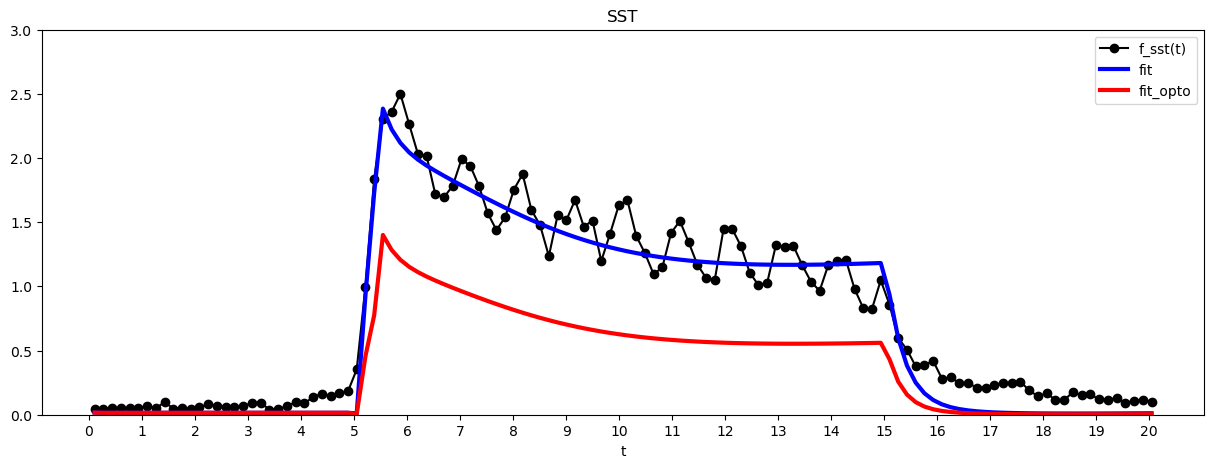

In [579]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 3.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [580]:
print(model['f_sst'].values)
print(model['f_sst_o'].values)
print(model['f_sst'].values/model['f_sst_o'].values)
print((model['f_sst'].values/model['f_sst_o'].values).mean())
print((model['f_sst_o'].values/model['f_sst'].values).mean())
print(model['f_sst'].values.mean()/model['f_sst_o'].values.mean())
print(model['f_sst_o'].values.mean()/model['f_sst'].values.mean())

[0.017      0.01508125 0.01507922 0.01507919 0.01507922 0.01507918
 0.01507918 0.01507906 0.01507907 0.01507902 0.01507897 0.01507887
 0.015079   0.01507877 0.01507913 0.01507906 0.01507902 0.01507918
 0.01507932 0.01507924 0.0150792  0.01507937 0.01507921 0.01507931
 0.01507916 0.01507912 0.0150791  0.01507907 0.01507901 0.01507899
 0.01059061 0.92915658 1.72730959 2.38535767 2.22367341 2.1183003
 2.04447969 1.98817583 1.94147318 1.89994112 1.86114223 1.82377915
 1.78720672 1.7511522  1.71555267 1.68046027 1.64598626 1.61226786
 1.57944796 1.54766397 1.51703851 1.48767751 1.4596673  1.43307296
 1.40794083 1.38429766 1.362153   1.34150122 1.32232263 1.30458662
 1.28825249 1.27327217 1.25959168 1.24715289 1.2358944  1.22575353
 1.21666689 1.20857102 1.20140396 1.1951048  1.18961497 1.18487795
 1.18083987 1.17744957 1.17465863 1.1724215  1.17069533 1.16944013
 1.16861856 1.16819588 1.16813982 1.16842049 1.16901021 1.16988343
 1.17101664 1.17238813 1.17397787 1.17576761 1.17774045 1.17988

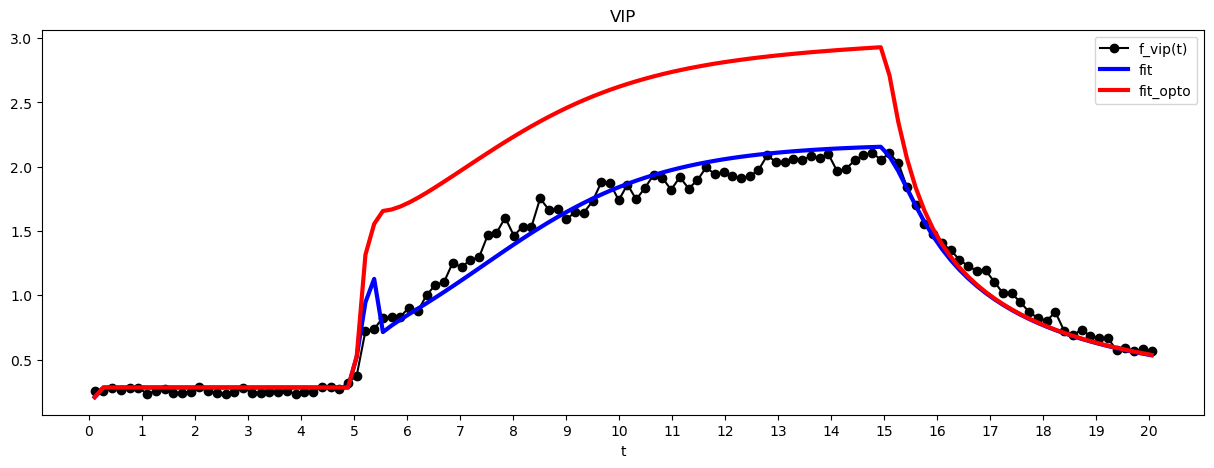

In [581]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [582]:
print(model['f_vip'].values)
print(model['f_vip_o'].values)

[0.208      0.28360335 0.28362531 0.28362526 0.28362532 0.28362524
 0.28362525 0.28362503 0.28362505 0.28362496 0.28362485 0.28362468
 0.28362491 0.28362449 0.28362515 0.28362503 0.28362495 0.28362525
 0.2836255  0.28362536 0.28362528 0.2836256  0.28362529 0.28362549
 0.28362521 0.28362514 0.2836251  0.28362504 0.28362493 0.28362489
 0.5228813  0.94653156 1.12818989 0.71475196 0.76568356 0.81111395
 0.85409821 0.89643328 0.93903903 0.9823495  1.02652166 1.07154682
 1.11731648 1.16365957 1.21036703 1.25720807 1.30394247 1.35032916
 1.39613417 1.44113561 1.48512983 1.52793374 1.56938724 1.60935614
 1.64773136 1.68442876 1.71938923 1.75257573 1.78397328 1.81358506
 1.84143049 1.86754397 1.89197124 1.91476718 1.93599495 1.95572267
 1.97402216 1.99096821 2.00663639 2.02110191 2.0344397  2.04672269
 2.05802149 2.06840449 2.077937   2.0866809  2.09469526 2.10203541
 2.10875348 2.11489834 2.12051556 2.12564762 2.13033391 2.13461099
 2.13851276 2.14207046 2.14531286 2.1482666  2.15095608 2.1534

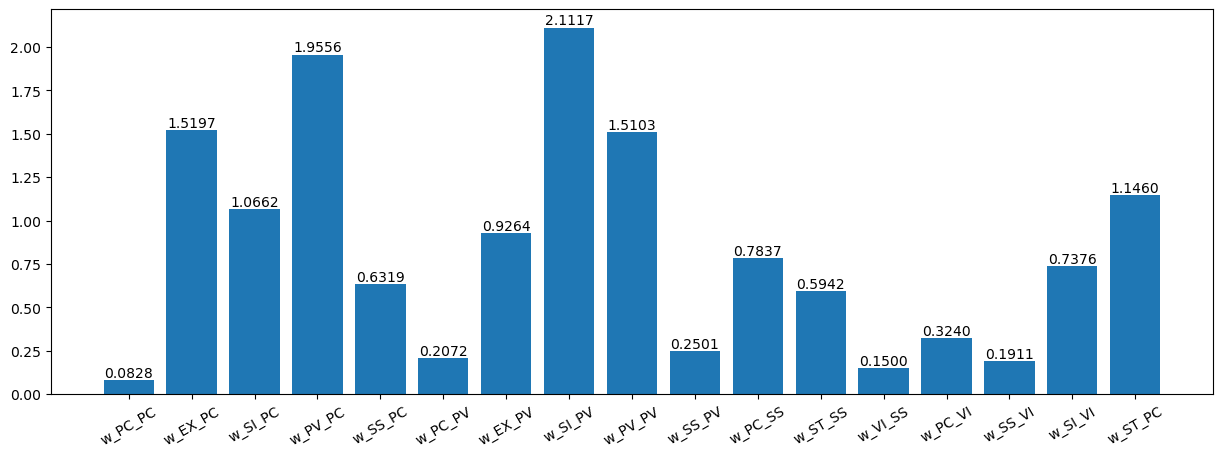

In [583]:
vals = []
for _, param in params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

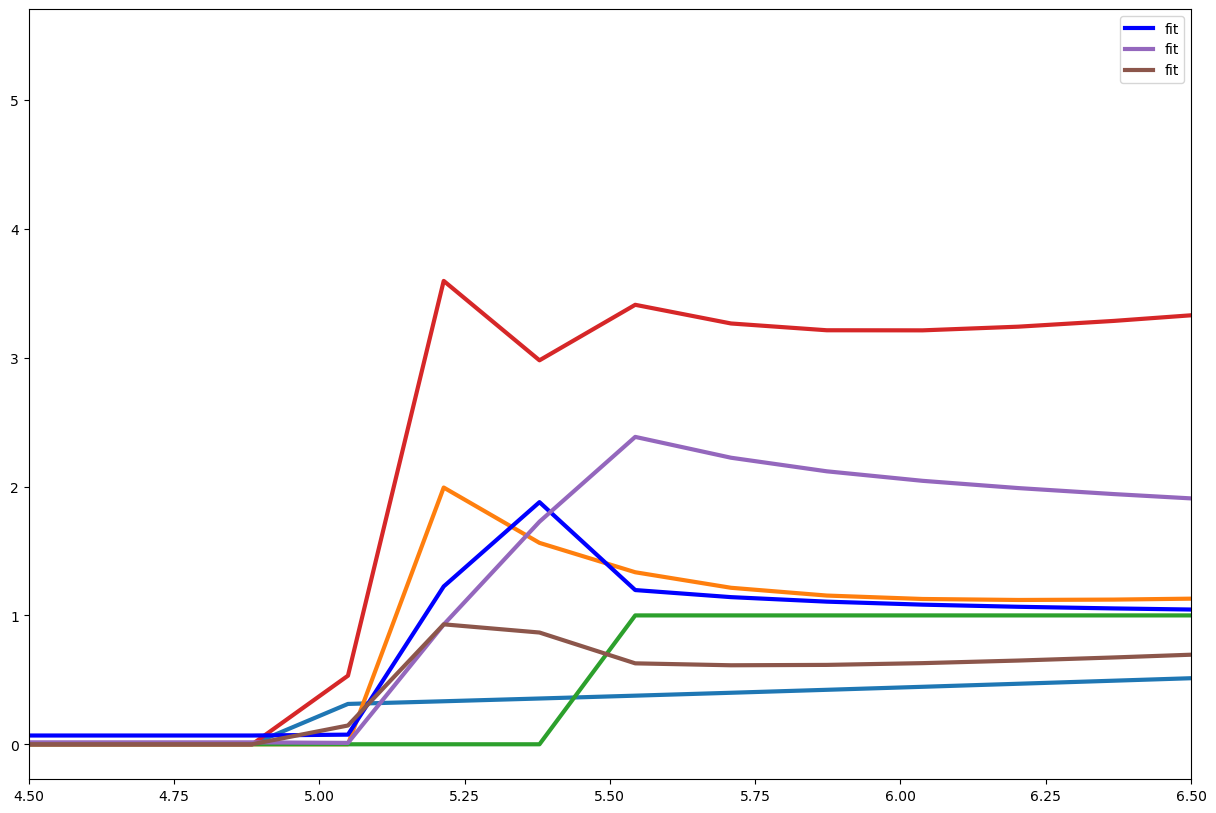

'\n ampl_1:     1.01359931 (init = 1)\n    r_1:        1.75139660 (init = 1.638479)\n    delay_1:    0.21200599 (init = 0.2032416)\n    delay_2:    1.45963700 (init = 1.400737)\n    delay_3:    0.41140712 (init = 0.363557)\n    decay:      3.51342590 (init = 3.702939)\n    decay_s:    0.29203316 (init = 0.3060473)\n    decay_f:    0.5 (fixed)\n    decay_ff:   1.39646321 (init = 0.5)\n    ampl:       1.05399785 (init = 1.093407)\n    base:       1 (fixed)\n    base_sigm:  0 (fixed)\n'

In [584]:
sig = []
ex = []
st = []
for i in t_exp:
    sig.append(Sigm(i, ampl = 1.01359931, rate = 1.75139660, delay = 1.45963700, decay_s = 0.29203316, base = 0))
    ex.append(expon(i, ampl = ampl, base = 1, decay = 3.51342590, delay = 0.21200599, decay_ff = 1.39646321))
    st.append(Step(i, k = 0, delay = 0.41140712, decay_f = 0.5))
    
plt.figure(figsize = (15,10))
plt.plot(t_exp, np.array(sig), linewidth = 3)
plt.plot(t_exp, np.array(ex), linewidth = 3)
plt.plot(t_exp, np.array(st), linewidth = 3)
plt.plot(t_exp, 1.7*np.array(sig)+1.52*np.array(ex)+0.74*np.array(st), linewidth = 3)
plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_sst'].values, label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv'].values, label='fit', linewidth=3)
#plt.plot(t_exp, data_pc_all, label = 'pc', linewidth = 1)
#plt.plot(t_exp, data_pv, label = 'pv', linewidth = 1)
#plt.plot(t_exp, data_sst, label = 'sst', linewidth = 1)
#plt.plot(t_exp, data_vip, label = 'vip', linewidth = 1)
plt.legend()
plt.xlim(4.5, 6.5)
plt.show()


"""
 ampl_1:     1.01359931 (init = 1)
    r_1:        1.75139660 (init = 1.638479)
    delay_1:    0.21200599 (init = 0.2032416)
    delay_2:    1.45963700 (init = 1.400737)
    delay_3:    0.41140712 (init = 0.363557)
    decay:      3.51342590 (init = 3.702939)
    decay_s:    0.29203316 (init = 0.3060473)
    decay_f:    0.5 (fixed)
    decay_ff:   1.39646321 (init = 0.5)
    ampl:       1.05399785 (init = 1.093407)
    base:       1 (fixed)
    base_sigm:  0 (fixed)
"""

In [585]:
inp = pd.DataFrame()
inp['t'] = t_exp
inp['FF'] = ex
inp['SM'] = sig
inp['FB'] = st
inp

,t,FF,SM,FB
0,0.107095,0.000000,0.000000,0.000000
1,0.271840,0.000000,0.000000,0.000000
2,0.436585,0.000000,0.000000,0.000000
3,0.601330,0.000000,0.000000,0.000000
4,0.766075,0.000000,0.000000,0.000000
...,...,...,...,...
117,19.382259,0.004330,0.279752,0.111790
118,19.547005,0.003440,0.266611,0.102951
119,19.711750,0.002733,0.254088,0.094811
120,19.876495,0.002171,0.242153,0.087314


In [586]:
inp[['t', 'FF', 'SM', 'FB']].to_csv('out_inputs.csv', index=False)

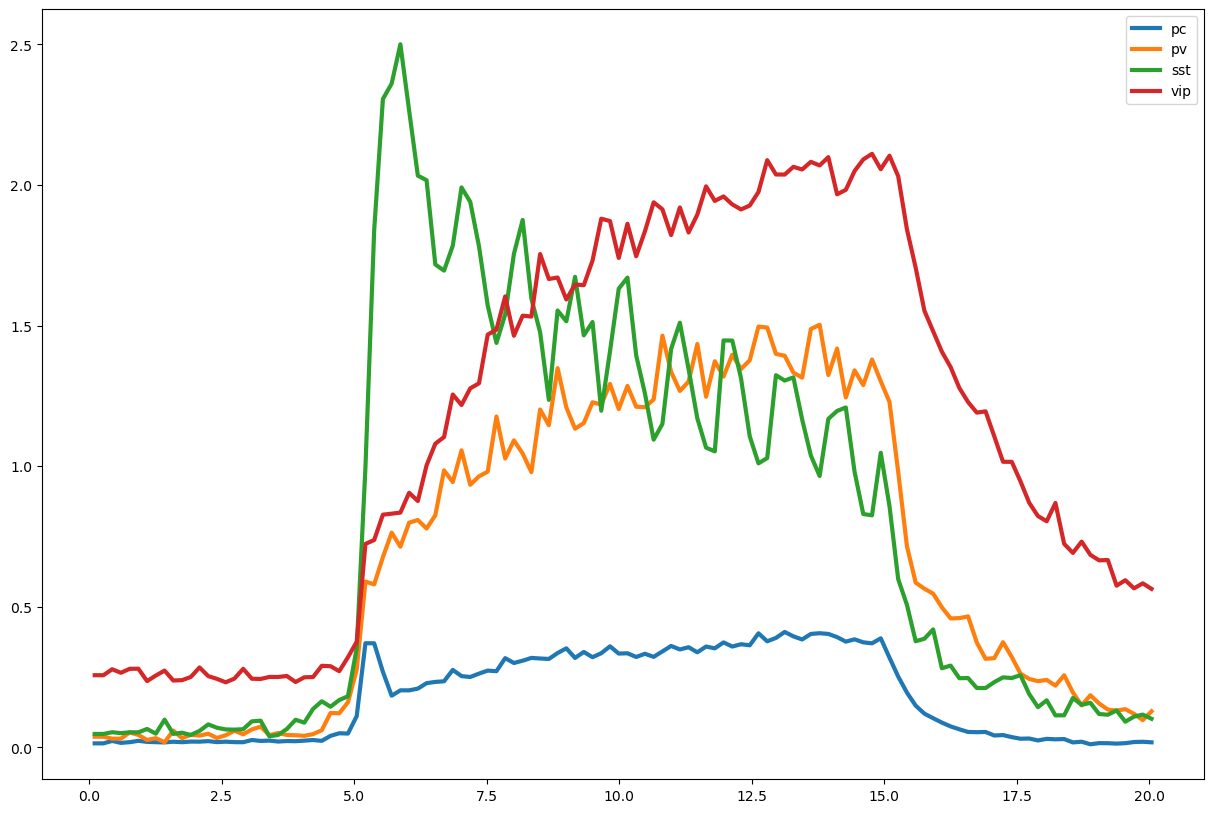

In [587]:
plt.figure(figsize = (15,10))
# plt.plot(t_exp, np.array(sig)*1.4 +0.4)
# plt.plot(t_exp, np.array(ex))
# plt.plot(t_exp, np.array(st))
plt.plot(t_exp, data_pc_sen, label = 'pc', linewidth = 3)
plt.plot(t_exp, data_pv, label = 'pv', linewidth = 3)
plt.plot(t_exp, data_sst, label = 'sst', linewidth = 3)
plt.plot(t_exp, data_vip, label = 'vip', linewidth = 3)
plt.legend()
#plt.xlim(4.5, 5.5)
plt.show()

In [588]:
for i in t_exp:
    print(i, expon(i, ampl = 0.5, base = 1.05259920, decay = 5.12622052, delay = 0.54586319))

0.107095 0
0.27184 0
0.436585 0
0.60133 0
0.766075 0
0.93082 0
1.095565 0
1.26031 0
1.425055 0
1.5898 0
1.754545 0
1.91929 0
2.084035 0
2.24878 0
2.413525 0
2.57827 0
2.743015 0
2.90776 0
3.072505 0
3.23725 0
3.401995 0
3.56674 0
3.731485 0
3.89623 0
4.060975 0
4.22572 0
4.390465 0
4.55521 0
4.719955 0
4.8847 0
5.049445 0
5.21419 0
5.378935 0
5.54368 0
5.708425 1.276155666735685
5.87317 1.1687177656651375
6.037915 1.1319390854504379
6.20266 1.1255273410973428
6.367405 1.1321661428803123
6.53215 1.1444136029782945
6.696895 1.1590715083089707
6.86164 1.1747652753703985
7.026385 1.1909042359291033
7.19113 1.2072345721602131
7.355875 1.2236470871705483
7.52062 1.2400949399103167
7.685365 1.2565580272058878
7.85011 1.2730275936347732
8.014855 1.2895000127150915
8.1796 1.3059735419123186
8.344345 1.3224476845431028
8.50909 1.338922049822996
8.673835 1.3553964154221185
8.83858 1.3718709175107484
9.003325 1.3883454372723991
9.16807 1.4048198692618534
9.332815 1.4212943998828498
9.49756 1.43776

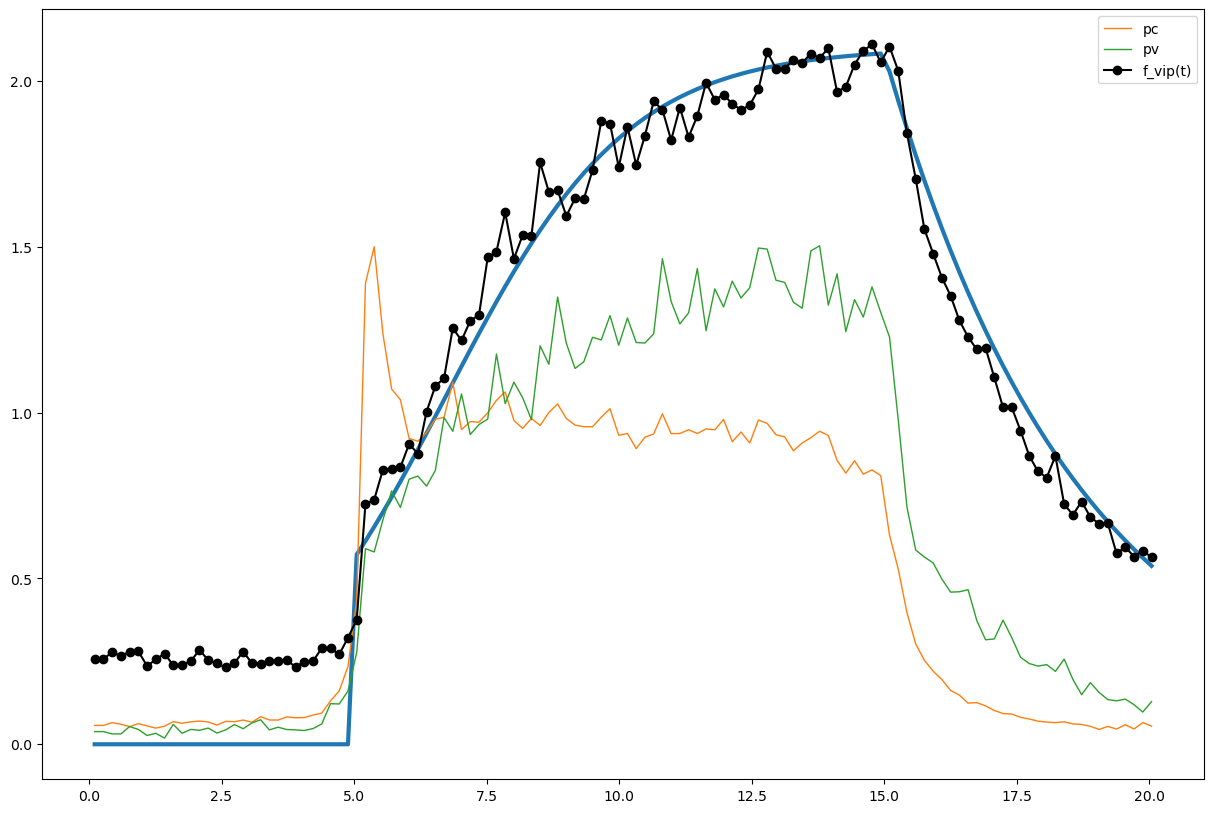

In [373]:
sig = []
#ex = []
#st = []
for i in t_exp:
    sig.append(Sigm(i, ampl = 1.0, rate = 1.713939, delay = 1.73305, decay_s = 0.2685497, base = 0))
    #ex.append(expon(i, ampl = ampl, base = 1, decay = result_nelder.params["decay"].value, delay = result_nelder.params["delay_1"].value, decay_ff = result_nelder.params["decay_ff"].value, s_start = result_nelder.params["s_start"].value, k = result_nelder.params["k"].value))
    #st.append(Step(i, k = 0, delay = 0.41140712, decay_f = 0.5))
    
plt.figure(figsize = (15,10))
plt.plot(t_exp, np.array(sig)*2.1, linewidth = 3)
#plt.plot(t_exp, np.array(ex), linewidth = 3)
#plt.plot(t_exp, np.array(st), linewidth = 3)
#plt.plot(t_exp, 1.7*np.array(sig)+1.52*np.array(ex)+0.74*np.array(st), linewidth = 3)
#plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, model['f_sst'].values, label='fit', linewidth=3)
#plt.plot(t_exp, model['f_pv'].values, label='fit', linewidth=3)
plt.plot(t_exp, data_pc_all, label = 'pc', linewidth = 1)
plt.plot(t_exp, data_pv, label = 'pv', linewidth = 1)
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
#plt.plot(t_exp, data_sst, label = 'sst', linewidth = 1)
#plt.plot(t_exp, data_vip, label = 'vip', linewidth = 1)
plt.legend()
#plt.xlim(4.5, 6.5)
plt.show()

# Solve

## leastsq (Levenberg-Marquardt)

In [63]:
count = 0

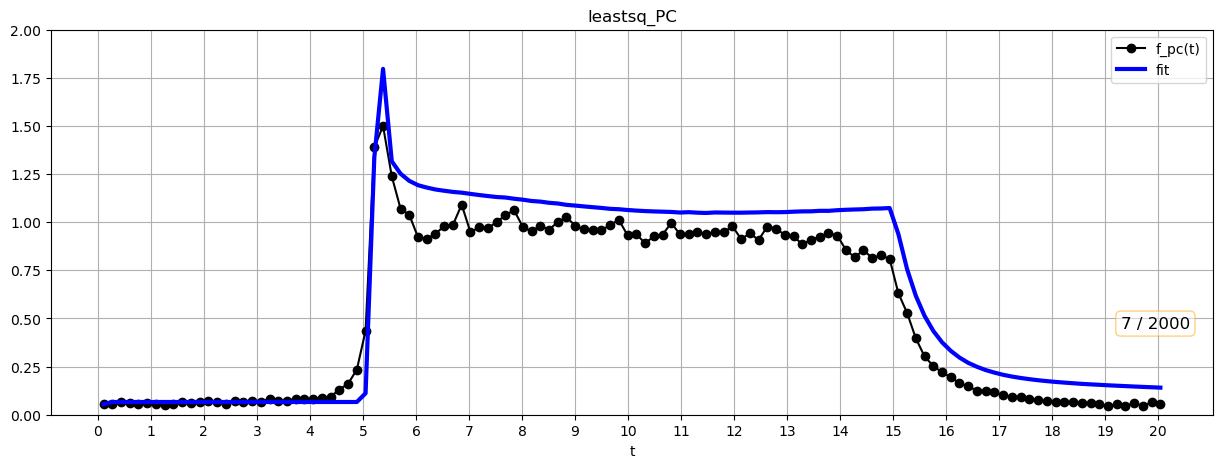

KeyboardInterrupt: 

In [64]:
%%time
%matplotlib inline

result_leastsq = minimize(residual_step, params, method='least_squares', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=30, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [65]:
report_fit(result_leastsq)

NameError: name 'result_leastsq' is not defined

In [ ]:
vals = []
for _, param in result_leastsq.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

In [ ]:
sim_leastsq = simulate_step(t_exp, init, params)
fit_leastsq = simulate_step(t_exp, init, result_leastsq.params)
step = []

for i in t_exp:
    step.append(Step(i))
    
curve = np.array(step) * result_leastsq.params['w_1'].value
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsq['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsq['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsq['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsq['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

## least_squares

In [ ]:
count = 0

In [ ]:
%%time
%matplotlib inline

result_leastsqs = minimize(residual_step, params, method='leastsq', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=30, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [ ]:
report_fit(result_leastsqs)

In [ ]:
vals = []
for _, param in result_leastsqs.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

In [ ]:
sim_leastsqs = simulate_step(t_exp, init, params)
fit_leastsqs = simulate_step(t_exp, init, result_leastsqs.params)
step = []

for i in t_exp:
    step.append(Step(i))
    
curve = np.array(step) * result_leastsqs.params['w_1'].value
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsqs['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsqs_PC')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsqs['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsqs['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsqs['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

## nelder

In [66]:
count = 0

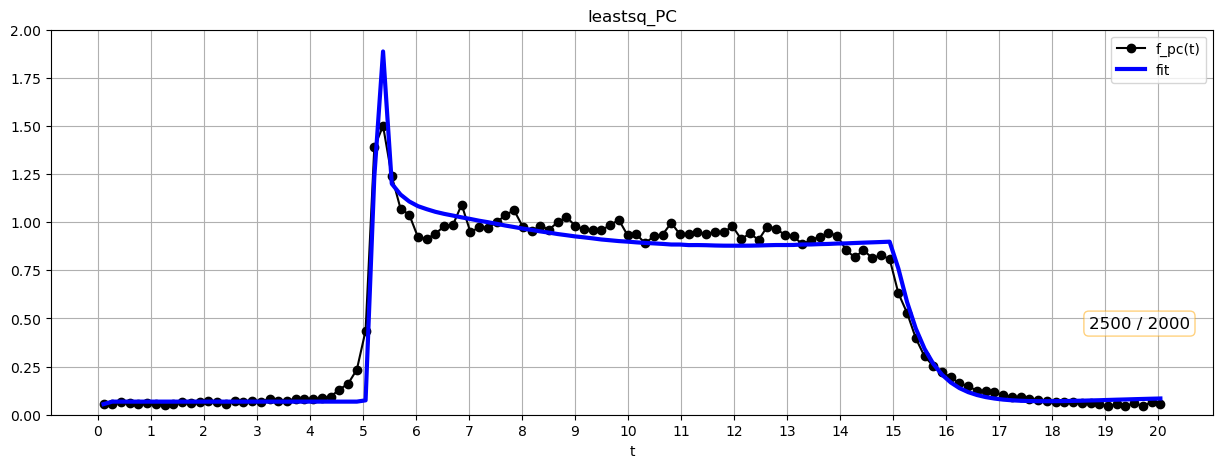


CPU times: total: 59min 20s
Wall time: 1h 4min 49s


In [67]:
%%time

%matplotlib inline

result_nelder = minimize(residual_step, params, method='nelder', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', options = {'adaptive' : True}, max_nfev = 2500)
print()


In [68]:
report_fit(result_nelder)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2501
    # data points      = 488
    # variables        = 34
    chi-square         = 4522.05323
    reduced chi-square = 9.96046966
    Akaike info crit   = 1154.48614
    Bayesian info crit = 1296.95686
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.08281103 (init = 0.08305636)
    w_1:        1.51969985 (init = 1.467154)
    w_2:        1.06618999 (init = 1.397314)
    w_3:        1.95560664 (init = 1.957842)
    w_4:        0.63190096 (init = 0.6209238)
    w_5:        0.20723919 (init = 0.1732922)
    w_6:        0.92636845 (init = 0.9164389)
    w_7:        2.11169434 (init = 2.105292)
    w_8:        1.51029559 (init = 1.38118)
    w_9:        0.25013329 (init = 0.3261505)
    w_10:       0.78370724 (init = 0.8955549)
    w_11:       0.59415933 (init = 0.6046628)
    w_12:       0.14997032 (init = 0.1912277)
    w_13:       0.32398988 (init = 0.6)
    w_14:      

In [164]:
a_nelder = RMSE_full(result_nelder.params, init, data_pc_all, data_pv, data_sst, data_vip)
print(a_nelder)

0.11420867318440693


In [146]:
m = simulate_step(t_exp, init, result_nelder.params)
a1 = np.sum((m["f_e"].values - data_pc_all)**2)
a2 = np.sum((m["f_pv"].values - data_pv)**2)
a3 = np.sum((m["f_sst"].values - data_sst)**2)
a4 = np.sum((m["f_vip"].values - data_vip)**2)
a5 = (a1+a2+a3+a4)
print(a1, a2, a3, a4, a5, np.sqrt(a5))

0.6417373014270518 1.4836405624628597 3.122257284293001 1.1102565594104936 6.357891707593406 2.5214860117782543


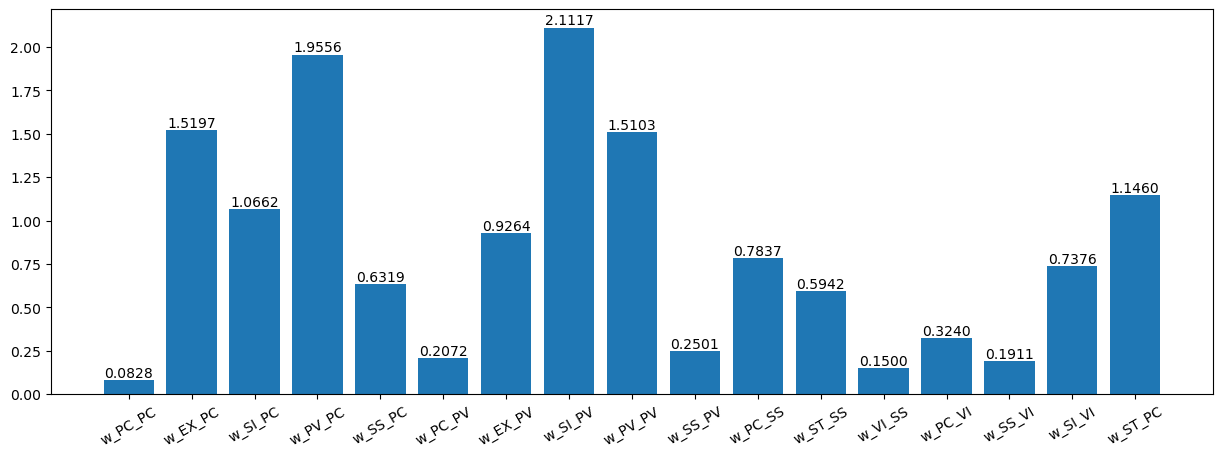

In [69]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

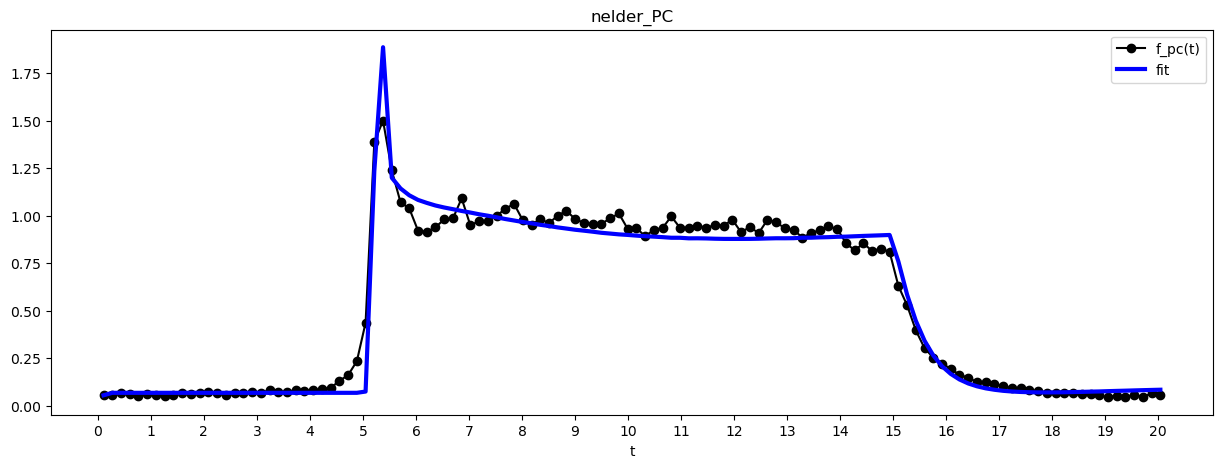

In [70]:
sim_nelder = simulate_step(t_exp, init, params)
fit_nelder = simulate_step(t_exp, init, result_nelder.params)
step_pv = []
#step_sst = []
# step = []

# for i in t_exp:
#     #step_sst.append(f_s(i, data_sst_exc))
#     step.append(Step(i, amp = 0.5, base = 0.0))
    
# curve =np.array(step) * result_nelder.params['w_2'].value

plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_nelder['f_e'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('nelder_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 5)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

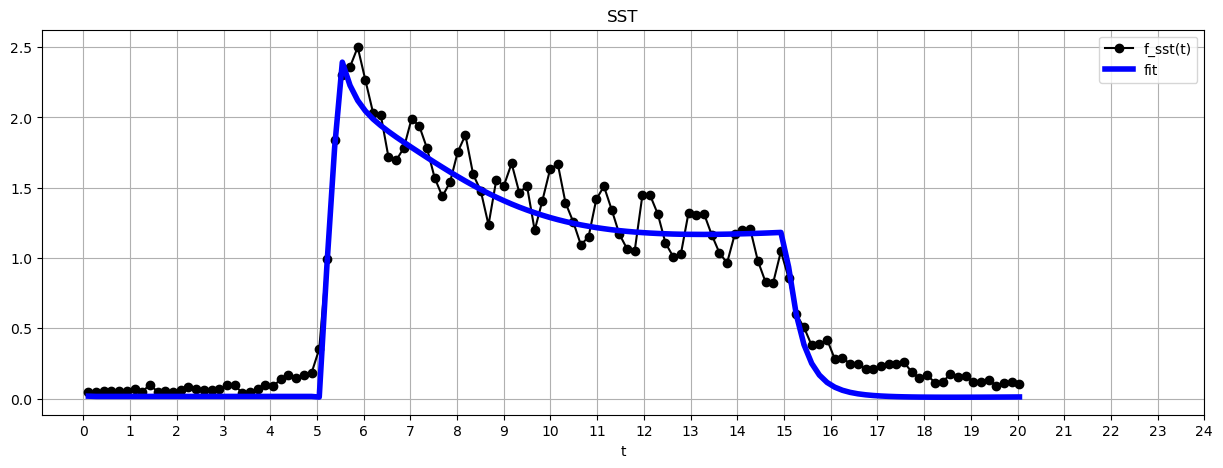

In [71]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_nelder['f_sst'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.ylim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

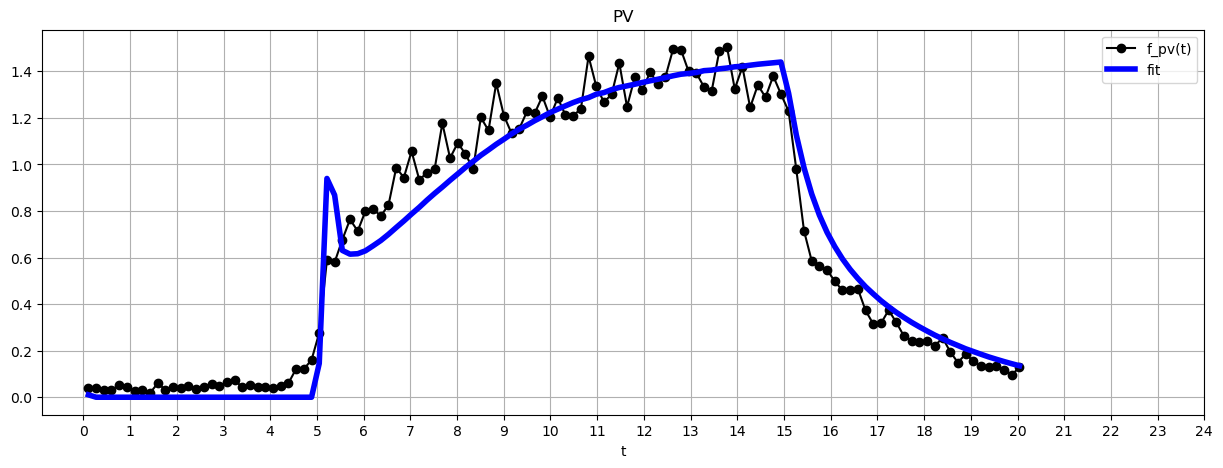

In [72]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_nelder['f_pv'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

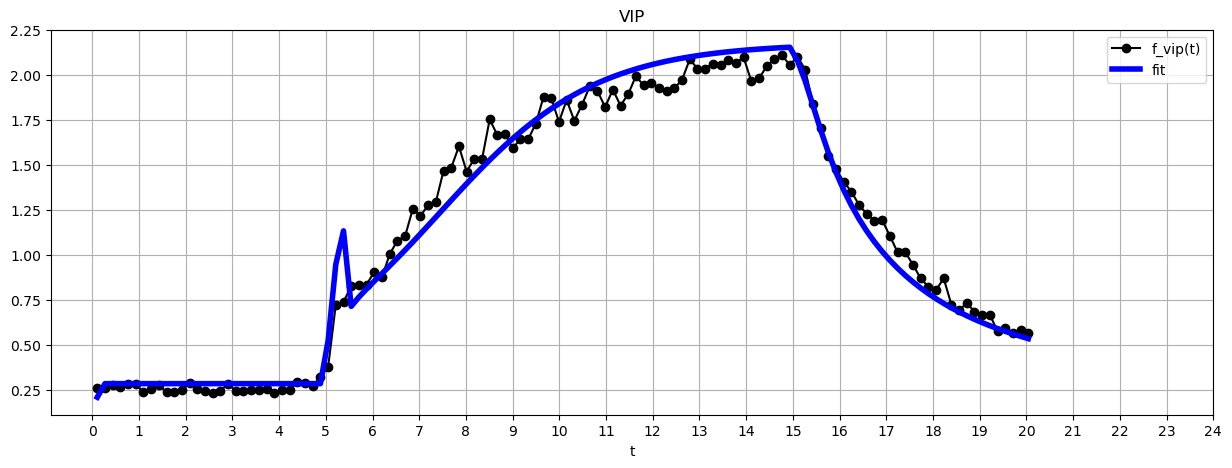

In [73]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_nelder['f_vip'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [201]:
model_opto = simulate_step(t_exp, init, result_nelder.params)

In [173]:
model_opto[['t', 'f_e', 'f_pv', 'f_sst', 'f_vip']].to_csv('traces_s1_hab_Loco_27_03_2025.csv', index=False)

In [187]:
model_opto[['t', 'f_e_o']].to_csv('trace_s1_hab_Loco_PVChr_27_03_2025.csv', index=False)

In [203]:
a = RMSE(result_nelder.params, init, data_pc_opto_sst_chr, "f_e_o")
print(a)

0.05450336897138607


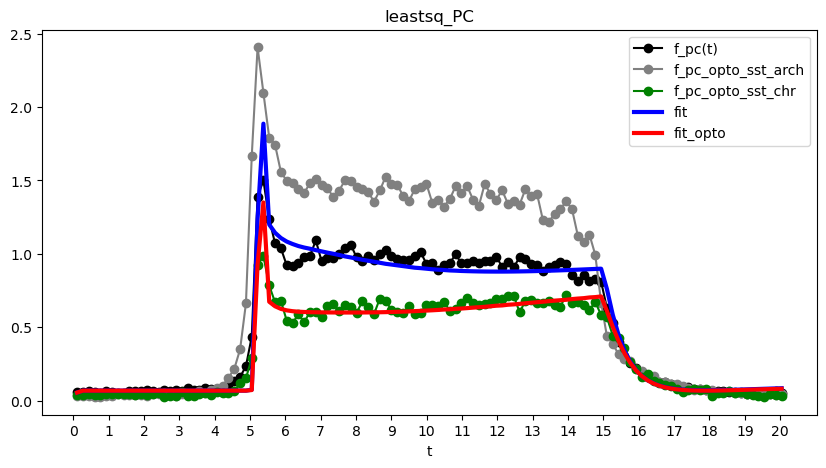

In [204]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
#plt.plot(t_exp, data_pc_opto_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_opto_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
plt.plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
plt.plot(t_exp, data_pc_opto_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
plt.plot(t_exp, model_opto['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)
#plt.grid()
plt.show()

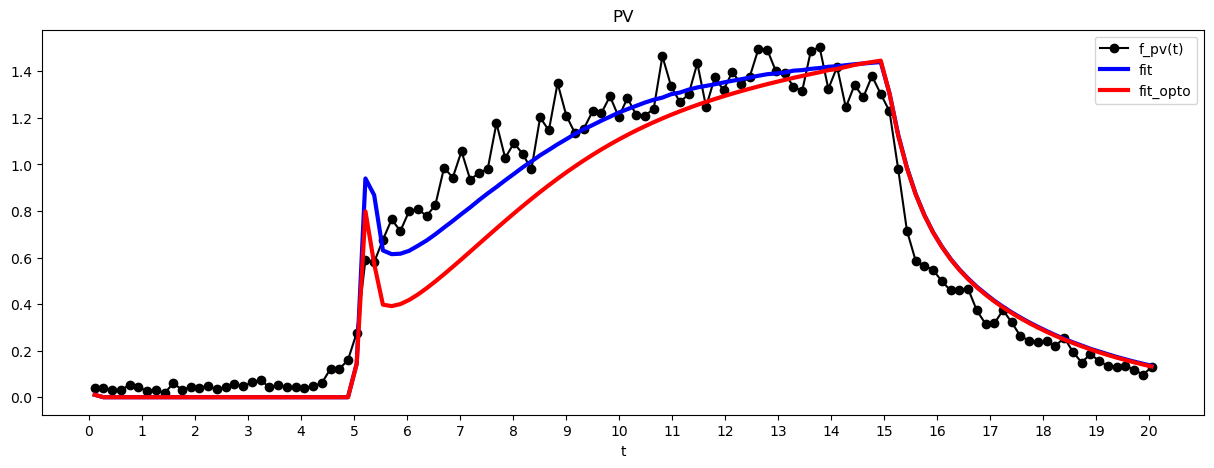

In [76]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, data_pc_all, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, fast, color='green', label='fit', linewidth=3)
#plt.plot(t_exp, slow, color='orange', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

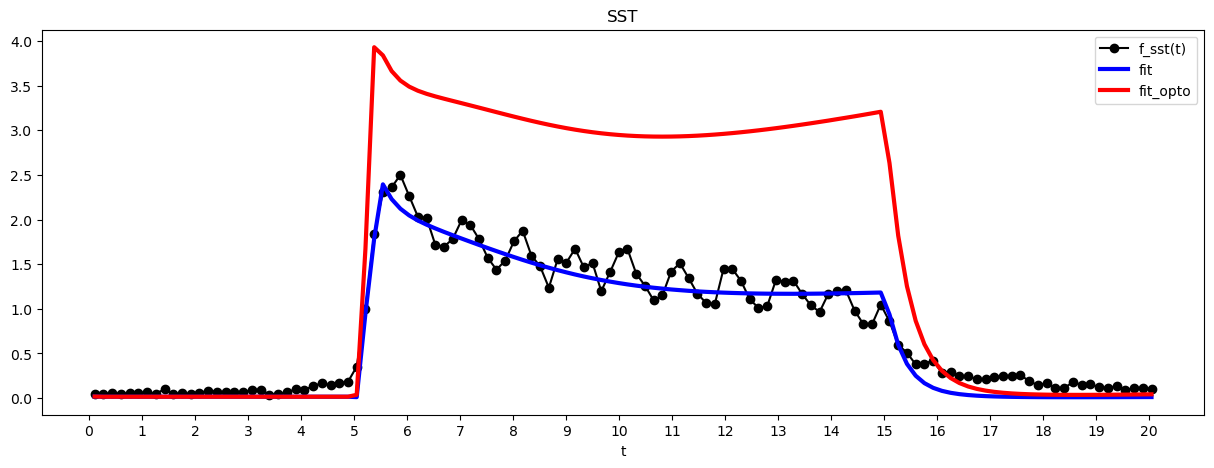

In [77]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

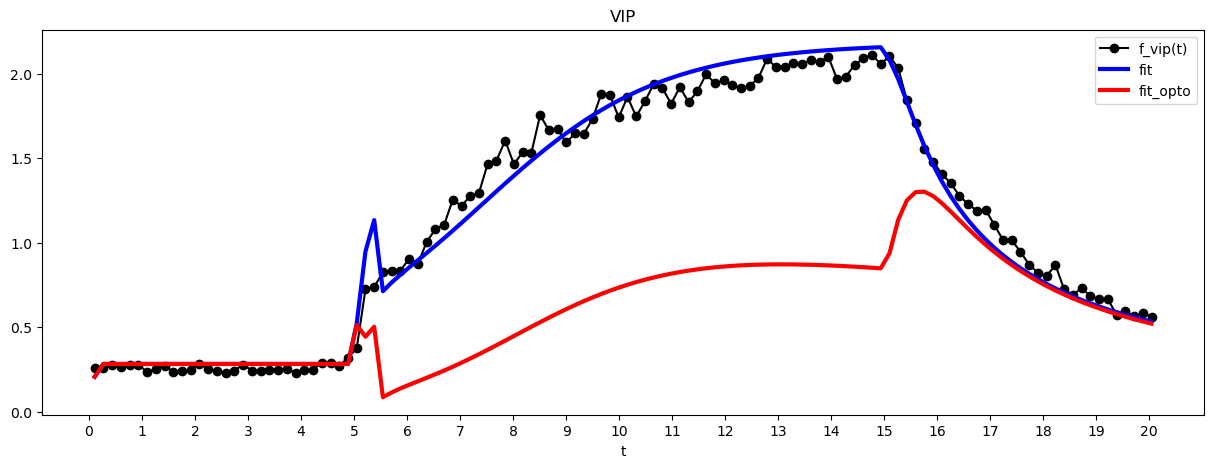

In [78]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

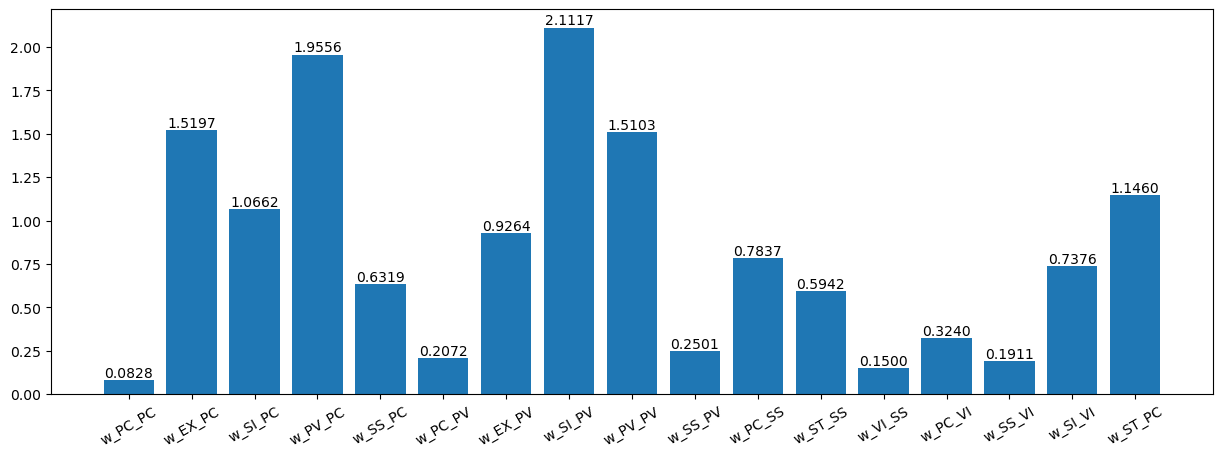

In [79]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

In [80]:
heat = pd.DataFrame()
heat[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
heat['PC'] = [0.01222982, 2.25251760, 2.70988047, None, 0.97270781, 1.53293469, 1.32938450]
heat['PV'] = [0.66931084, 1.39211370, 1.14684455, None, 0.22043244, 1.90878325, None]
heat['SST'] = [0.17210378, None, None, 0.15543846, None, None, 0.65516905]
heat['VIP'] = [0.04639222, None, 0.00206863, None, None, 0.79944357, None]
heat.set_index('', inplace = True)

In [168]:
heat_new_ = pd.DataFrame()
heat_new_[''] = ['PC', 'SST', 'PV', 'VIP_P', 'RMSE']

heat_new_['PC'] = [result_nelder.params["w_0"].value,
                  result_nelder.params["w_10"].value,
                  result_nelder.params["w_5"].value,
                  result_nelder.params["w_13"].value,
                  None]

heat_new_['SST'] = [result_nelder.params["w_4"].value,
                  None,
                  result_nelder.params["w_9"].value,
                  result_nelder.params["w_14"].value,
                  None]

heat_new_['PV'] = [result_nelder.params["w_3"].value,
                   None,
                   result_nelder.params["w_8"].value,
                   None,
                   None]

heat_new_['VIP_P'] = [None,
                   result_nelder.params["w_12"].value,
                   None,
                   None,
                   None]

heat_new_['FF'] = [result_nelder.params["w_1"].value,
                   None,
                   result_nelder.params["w_6"].value,
                   None,
                   None]

heat_new_['SM'] = [result_nelder.params["w_2"].value,
                   None,
                   result_nelder.params["w_7"].value,
                   result_nelder.params["w_15"].value,
                   None]

heat_new_['FB'] = [result_nelder.params["w_16"].value,
                   result_nelder.params["w_11"].value,
                   result_nelder.params["w_17"].value,
                   result_nelder.params["w_18"].value,
                   None]

heat_new_['RMSE'] = [None,
                   None,
                   None,
                   None,
                   a_nelder]

heat_new_.set_index('', inplace = True)

heat_new_.to_csv("heatmap_s1_hab_Loco_27_03_2025.csv")

In [169]:
heat_new_ = heat_new_.map(lambda x: np.nan if x is None else x)

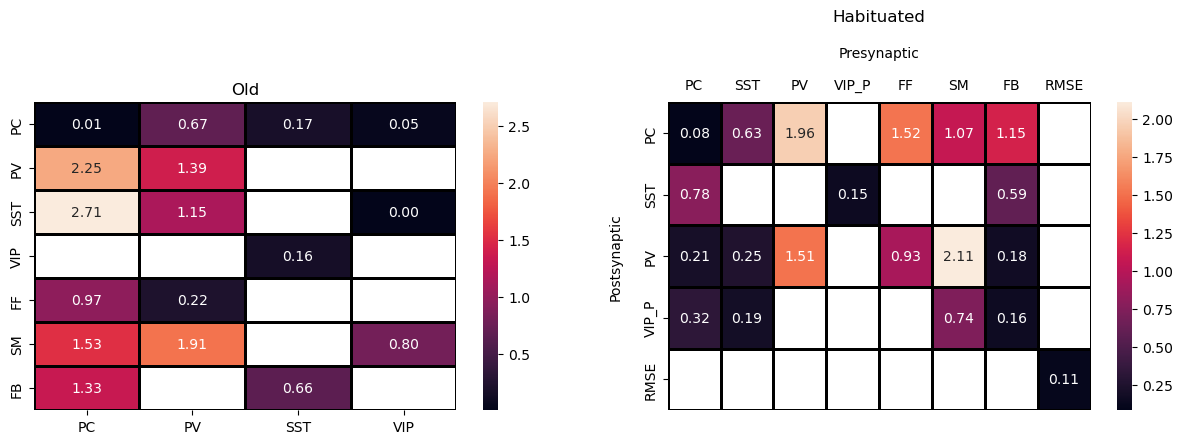

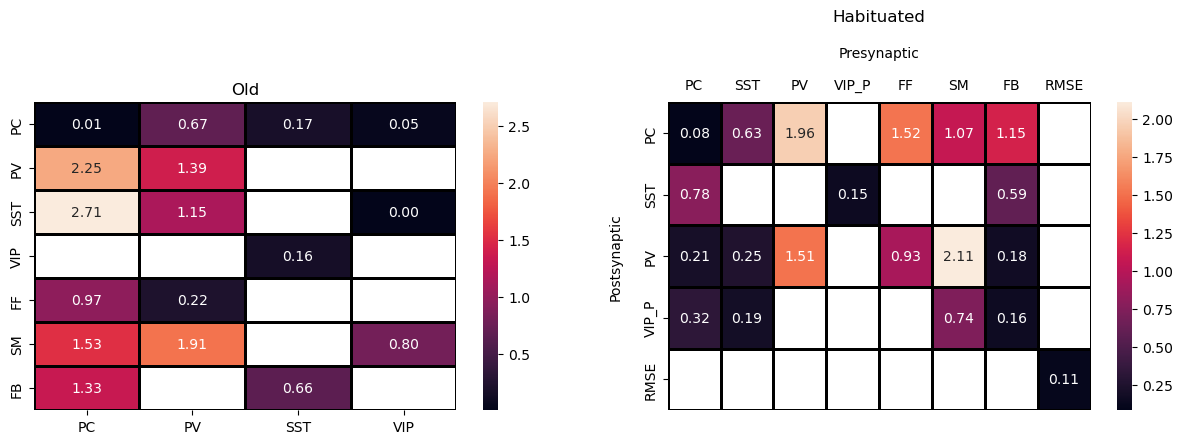

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(heat, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black', fmt=".2f")
sns.heatmap(heat_new_, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black', fmt=".2f")
ax[0].set_title("Old")
ax[1].set_title("New")
ax[1].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[1].title.set_text("Habituated")
ax[1].xaxis.set_label_position("top")
display.display(fig)

In [1]:
sig = []
ex = []
#st = []
for i in t_exp:
    sig.append(Sigm(i, ampl = 1.01359931, rate = 1.75139660, delay = 1.45963700, decay_s = 0.29203316, base = 0))
    ex.append(expon(i, ampl = ampl, base = 1, decay = result_nelder.params["decay"].value, delay = result_nelder.params["delay_1"].value, decay_ff = result_nelder.params["decay_ff"].value, s_start = result_nelder.params["s_start"].value, k = result_nelder.params["k"].value))
    #st.append(Step(i, k = 0, delay = 0.41140712, decay_f = 0.5))
    
plt.figure(figsize = (15,10))
plt.plot(t_exp, np.array(sig), linewidth = 3)
plt.plot(t_exp, np.array(ex), linewidth = 3)
#plt.plot(t_exp, np.array(st), linewidth = 3)
#plt.plot(t_exp, 1.7*np.array(sig)+1.52*np.array(ex)+0.74*np.array(st), linewidth = 3)
#plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, model['f_sst'].values, label='fit', linewidth=3)
#plt.plot(t_exp, model['f_pv'].values, label='fit', linewidth=3)
plt.plot(t_exp, data_pc_all, label = 'pc', linewidth = 1)
plt.plot(t_exp, data_pv, label = 'pv', linewidth = 1)
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
#plt.plot(t_exp, data_sst, label = 'sst', linewidth = 1)
#plt.plot(t_exp, data_vip, label = 'vip', linewidth = 1)
plt.legend()
#plt.xlim(4.5, 6.5)
plt.show()


"""
 ampl_1:     1.01359931 (init = 1)
    r_1:        1.75139660 (init = 1.638479)
    delay_1:    0.21200599 (init = 0.2032416)
    delay_2:    1.45963700 (init = 1.400737)
    delay_3:    0.41140712 (init = 0.363557)
    decay:      3.51342590 (init = 3.702939)
    decay_s:    0.29203316 (init = 0.3060473)
    decay_f:    0.5 (fixed)
    decay_ff:   1.39646321 (init = 0.5)
    ampl:       1.05399785 (init = 1.093407)
    base:       1 (fixed)
    base_sigm:  0 (fixed)
    expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, exp_start = exp_start, decay_exp = decay_exp)
"""

np.savetxt("FF_27_03_2025.csv", np.array(ex))

NameError: name 't_exp' is not defined

## L-BFGS-B

In [85]:
# count = 0

In [86]:
# %%time
# %matplotlib inline
# result_lbfgsb = minimize(residual_step, params, method='lbfgsb', args=(t_exp, init, data_pc_sen, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=max_nfev/4, tol=1e-12)
# print()

In [87]:
# report_fit(result_lbfgsb)

In [88]:
# sim_lbfgsb = simulate_step(t_exp, init, params)
# fit_lbfgsb = simulate_step(t_exp, init, result_lbfgsb.params)
# # step = []

# # for i in t_exp:
# #     step.append(f_p(i, data_pv_exc))
    
# # curve = np.array(step) * result_lbfgsb.params['w_1'].value

# plt.figure(figsize=(10,5))
# plt.axis('auto')
# plt.plot(t_exp, pc_sen_new, color='black', marker='o', label='f_pc(t)')
# plt.plot(t_exp, fit_lbfgsb['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_lbfgsb['f_e'].values, color='red', label='init_fit')
# # plt.plot(t_exp, curve, color = (51/255, 255/255, 51/255), label='input')
# plt.title('PC_sen with "PV plasticity" + subpopulations', fontsize = 18)
# plt.legend(loc='upper left')
# plt.xlabel('time, s', fontsize=18)
# plt.ylabel('Firing rate, Hz', fontsize=18)
# plt.ylim(0, 0.6)
# plt.xticks(np.arange(0,21,1), size = 14)
# plt.yticks(size = 14)
# #plt.grid()

# # pars = (f"PC_sen:   {result_lbfgsb.params['w_0'].value:.6f} +/- {result_lbfgsb.params['w_0'].stderr:.6f}\n"
# #         f"PC_na:     {result_lbfgsb.params['w_1'].value:.6f} +/- {result_lbfgsb.params['w_1'].stderr:.6f}\n"
# #         f"PC_dep:   {result_lbfgsb.params['w_2'].value:.6f} +/- {result_lbfgsb.params['w_2'].stderr:.6f}\n"
# #         f"Input:      {result_lbfgsb.params['w_3'].value:.6f} +/- {result_lbfgsb.params['w_3'].stderr:.6f}\n"
# #         f"PV:           {result_lbfgsb.params['w_4'].value:.6f} +/- {result_lbfgsb.params['w_4'].stderr:.6f}\n"
# #         f"SST:         {result_lbfgsb.params['w_5'].value:.6f} +/- {result_lbfgsb.params['w_5'].stderr:.6f}\n"
# #         f"i_0:          {result_lbfgsb.params['i_0'].value:.6f} +/- {result_lbfgsb.params['i_0'].stderr:.6f}")

# # bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)

# # plt.text(14.0, 0.050, pars, fontsize=12, bbox=bbox, horizontalalignment='right')

# plt.show()

## powell

In [89]:
count = 0

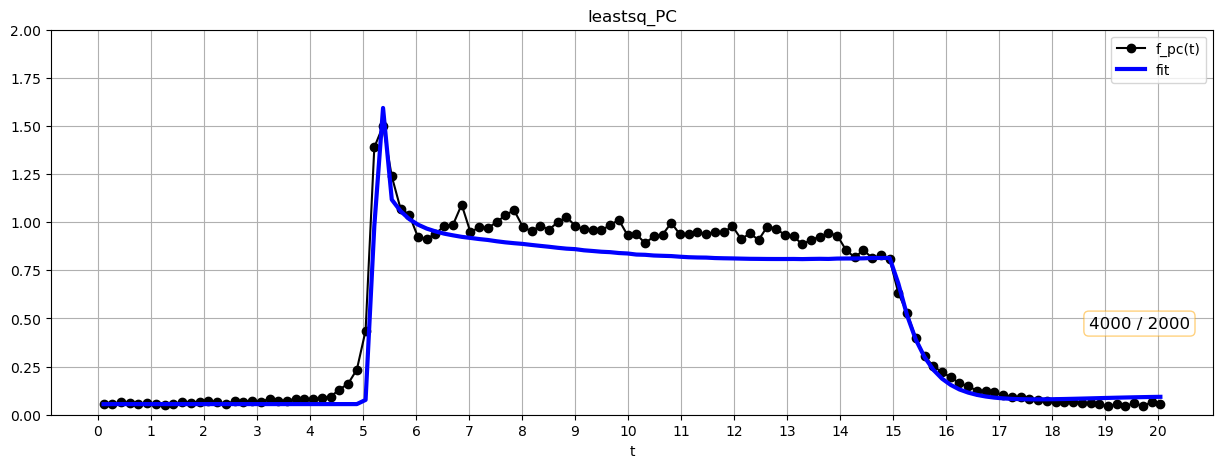


CPU times: total: 1h 13min 1s
Wall time: 1h 14min 13s


In [90]:
%%time
%matplotlib inline
result_powell = minimize(residual_step, params, method='powell', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), max_nfev = 2*max_nfev, nan_policy='propagate', tol=1e-14) #max_nfev = 4*max_nfev,
print()

In [91]:
report_fit(result_powell)

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 4001
    # data points      = 488
    # variables        = 34
    chi-square         = 5401.00093
    reduced chi-square = 11.8964778
    Akaike info crit   = 1241.16379
    Bayesian info crit = 1383.63452
##  Warning: uncertainties could not be estimated:
    w_13:       at boundary
    delay_3:    at initial value
[[Variables]]
    w_0:        0.05788712 (init = 0.08305636)
    w_1:        1.28159752 (init = 1.467154)
    w_2:        1.32879399 (init = 1.397314)
    w_3:        1.93461489 (init = 1.957842)
    w_4:        0.59518101 (init = 0.6209238)
    w_5:        0.18272453 (init = 0.1732922)
    w_6:        0.89952481 (init = 0.9164389)
    w_7:        2.13855860 (init = 2.105292)
    w_8:        1.39671360 (init = 1.38118)
    w_9:        0.32574755 (init = 0.3261505)
    w_10:       1.07579849 (init = 0.8955549)
    w_11:       0.58680514 (init = 0.6046628)
    w_12:       0.17897999 (init = 0.1912277)

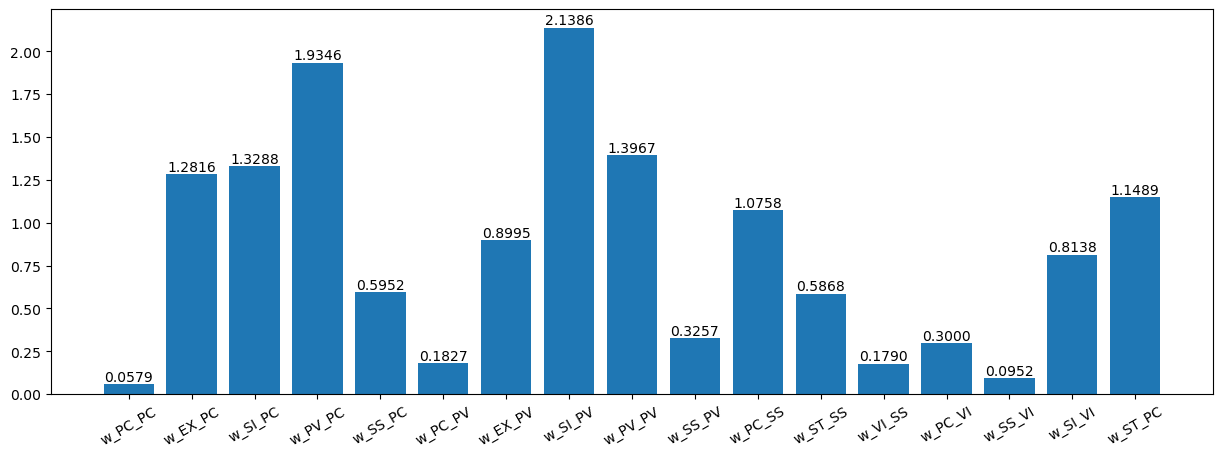

In [92]:
vals = []
for _, param in result_powell.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

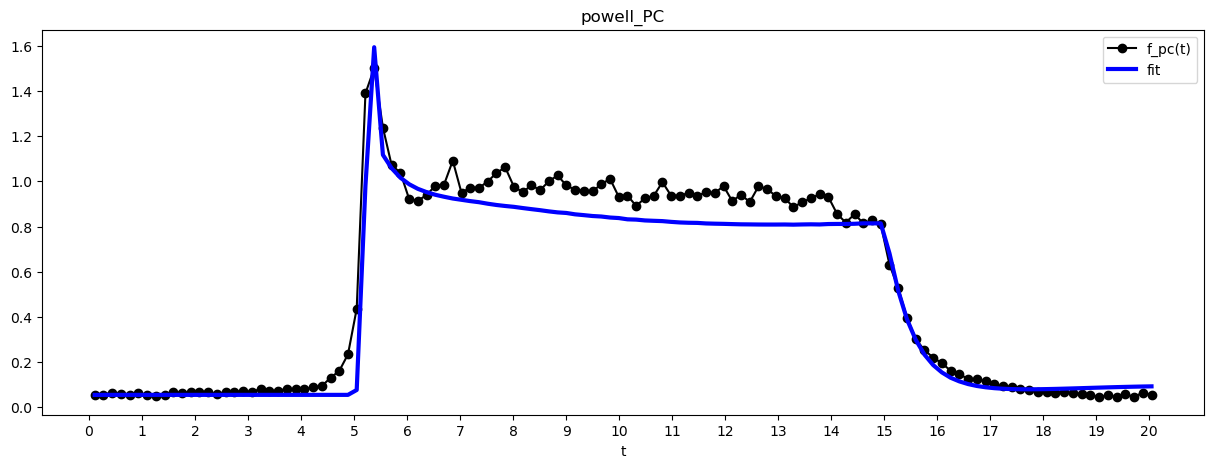

In [93]:
sim_powell = simulate_step(t_exp, init, params)
fit_powell = simulate_step(t_exp, init, result_powell.params)
# step = []

# for i in t_exp:
#     step.append(f_p(i, data_pv_exc))
    
# curve = np.array(step) * result_powell.params['w_1'].value

plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_powell['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_powell['f_e'].values, color='red', label='init_fit')
# plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('powell_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(-0.1, 0.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

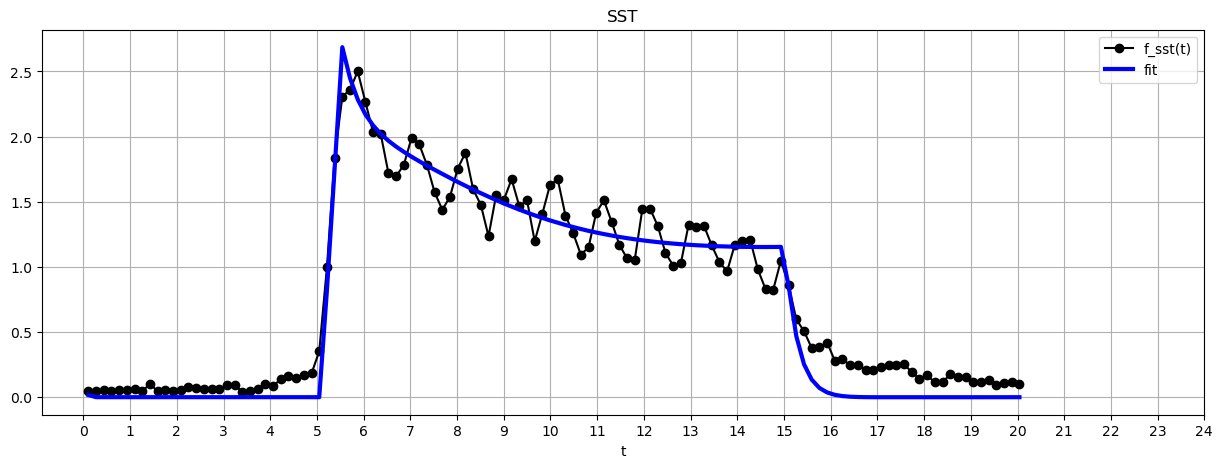

In [94]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_powell['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_powell['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

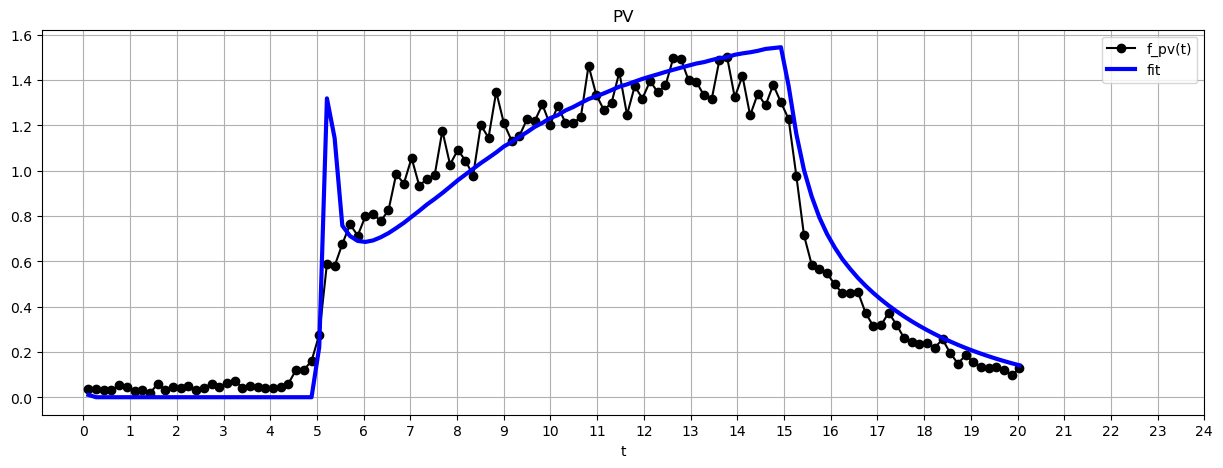

In [95]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_powell['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

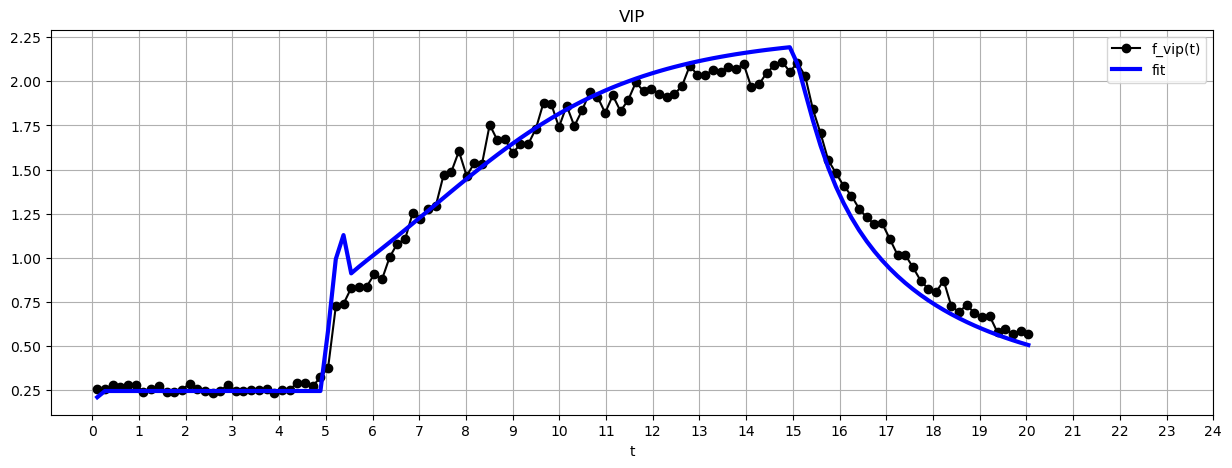

In [96]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_powell['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

# Global_optimization

## bassinhopping

In [97]:
# count = 0


In [98]:
# %%time
# %matplotlib inline
# result_bass = minimize(residual_step, params, method='dual_annealing', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=3*max_nfev)
# print()

In [99]:
# report_fit(result_bass)

In [100]:
# sim_bass = simulate_step(t_exp, init, params)
# fit_bass = simulate_step(t_exp, init, result_bass.params)
# # step = []

# # for i in t_exp:
# #     step.append(f_p(i, data_pv_exc))
    
# # curve = np.array(step) * result_powell.params['w_1'].value

# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
# plt.plot(t_exp, fit_bass['f_e'].values, color='blue', label='fit', linewidth=3)
# # plt.plot(t_exp, sim_powell['f_e'].values, color='red', label='init_fit')
# # plt.plot(t_exp, curve, color = 'green', label='input')
# plt.title('bass_PC')
# plt.legend(loc='best')
# plt.xlabel('t')
# #plt.ylim(-0.1, 0.6)
# plt.xticks(np.arange(0,21,1))
# #plt.grid()
# plt.show()

In [101]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, sst_new, color='black', marker='o', label='f_sst(t)')
# plt.plot(t_exp, fit_bass['f_sst'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_powell['f_sst'].values, color='red', label='init_fit')
# plt.title('SST')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [102]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pv_new, color='black', marker='o', label='f_pv(t)')
# plt.plot(t_exp, fit_bass['f_pv'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
# plt.title('PV')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [103]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, vip_new, color='black', marker='o', label='f_vip(t)')
# plt.plot(t_exp, fit_bass['f_vip'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
# plt.title('VIP')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

## ampgo

In [104]:
# count = 0

In [105]:
# %%time
# %matplotlib inline
# result_ampgo = minimize(residual_step, params, method='ampgo', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=4*max_nfev, local = 'Nelder-Mead')
# print()

In [106]:
# report_fit(result_ampgo)

In [107]:
# print(result_ampgo.success)

In [108]:
# sim_ampgo = simulate_step(t_exp, init, params)
# fit_ampgo = simulate_step(t_exp, init, result_ampgo.params)
# # step = []

# # for i in t_exp:
# #     step.append(f_p(i, data_pv_exc))
    
# # curve = np.array(step) * result_powell.params['w_1'].value

# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
# plt.plot(t_exp, fit_ampgo['f_e'].values, color='blue', label='fit', linewidth=3)
# # plt.plot(t_exp, sim_powell['f_e'].values, color='red', label='init_fit')
# # plt.plot(t_exp, curve, color = 'green', label='input')
# plt.title('ampgo_PC')
# plt.legend(loc='best')
# plt.xlabel('t')
# #plt.ylim(-0.1, 0.6)
# plt.xticks(np.arange(0,21,1))
# #plt.grid()
# plt.show()

In [109]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, sst_new, color='black', marker='o', label='f_sst(t)')
# plt.plot(t_exp, fit_ampgo['f_sst'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_powell['f_sst'].values, color='red', label='init_fit')
# plt.title('SST')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [110]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pv_new, color='black', marker='o', label='f_pv(t)')
# plt.plot(t_exp, fit_ampgo['f_pv'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
# plt.title('PV')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [111]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, vip_new, color='black', marker='o', label='f_vip(t)')
# plt.plot(t_exp, fit_ampgo['f_vip'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
# plt.title('VIP')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

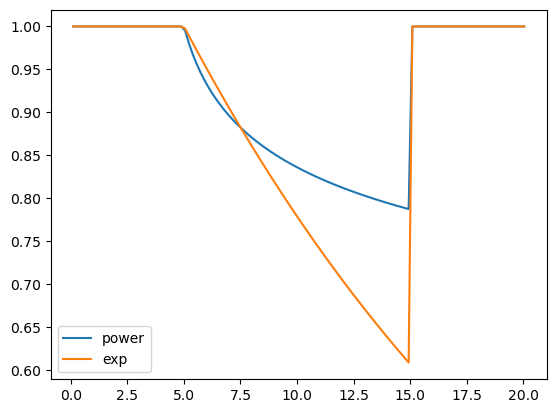

In [112]:
r = []
e = []
for t in t_exp:
    r.append(invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1, delta = 1))
    e.append(exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.05, amp = 1))
    
plt.plot(t_exp, r, label="power")
plt.plot(t_exp, e, label="exp")
plt.legend()
plt.show()